# Which Magnitude Should I Use?
Faced with this array of different magnitude measurements to choose from, which one is appropriate in which circumstances? We cannot give any guarantees of what is appropriate for the science you want to do, but here we present some examples, where we use the general guideline that one usually wants to maximize some combination of signal-to-noise ratio, fraction of the total flux included, and freedom from systematic variations with observing conditions and distance.

Given the excellent agreement between cmodel magnitudes (see cmodel magnitudes above) and PSF magnitudes for point sources, and between cmodel magnitudes and Petrosian magnitudes (albeit with intrinsic offsets due to aperture corrections) for galaxies, the cmodel magnitude is now an adequate proxy to use as a universal magnitude for all types of objects. As it is approximately a matched aperture to a galaxy, it has the great advantage over Petrosian magnitudes, in particular, of having close to optimal noise properties.

## Example magnitude usage
reference : [Measures of SDSS flux, magnitudes, and diameters](https://ned.ipac.caltech.edu/help/sdss/dr6/photometry.html)

- **Photometry of Bright Stars**: If the objects are bright enough, add up all the flux from the profile `profMean` and generate a large aperture magnitude. We recommend using the first 7 annuli.
- **Photometry of Distant Quasars**: These will be unresolved, and therefore have images consistent with the PSF. For this reason, `psfMag` is unbiased and optimal.
- **Colors of Stars**: Again, these objects are unresolved, and `psfMag` is the optimal measure of their brightness.
- **Photometry of Nearby Galaxies**: Galaxies bright enough to be included in our spectroscopic sample have relatively high signal-to-noise ratio measurements of their Petrosian magnitudes. Since these magnitudes are model-independent and yield a large fraction of the total flux, roughly constant with redshift, `petroMag` is the measurement of choice for such objects. In fact, the noise properties of Petrosian magnitudes remain good to r=20 or so.
- **Photometry of Galaxies**: Under most conditions, the `cmodel` magnitude is now a reliable estimate of the galaxy flux. In addition, this magnitude account for the effects of local seeing and thus are less dependent on local seeing variations.
- **Colors of Galaxies**: For measuring colors of extended objects, we continue to recommend using the `model` (**not the cmodel**) magnitudes. The model magnitude is calculated using the best-fit parameters in the r band, and applies it to all other bands; the light is therefore measured consistently through the same aperture in all bands.


### Petrosian magnitudes
This is stored as petroMag. For galaxy photometry, measuring flux is more difficult than for stars, because galaxies do not all have the same radial surface brightness profile, and have no sharp edges. In order to avoid biases, it is necessary to measure a constant fraction of the total light, independent of the position and distance of the object. To satisfy these requirements, the SDSS has adopted a modified form of the Petrosian (1976) system, measuring galaxy fluxes within a circular aperture whose radius is defined by the shape of the azimuthally averaged light profile.

The SDSS defines the “Petrosian ratio” RP at a radius r from the center of an object to be the ratio of the local surface brightness in an annulus at r to the mean surface brightness within r, as described by Blanton et al. 2001a, Yasuda et al. 2001:
![Petrosian Equation 1](./images/GalWCls19_summary.gif)
where I(r) is the azimuthally averaged surface brightness profile.

The Petrosian radius rP is defined as the radius at which RP(rP) equals some specified value RP,lim, set to 0.2 in this case. The Petrosian flux in any band is then defined as the flux within a certain number NP (equal to 2.0 in this case) of r Petrosian radii:
![Petrosian Equation 2](./images/petroeq2.gif)
In the SDSS five-band photometry, the aperture in all bands is set by the profile of the galaxy in the r band alone. This procedure ensures that the color measured by comparing the Petrosian flux FP in different bands is measured through a consistent aperture.

The aperture 2rP is large enough to contain nearly all of the flux for typical galaxy profiles, but small enough that the sky noise in FP is small. Thus, even substantial errors in rP cause only small errors in the Petrosian flux (typical statistical errors near the spectroscopic flux limit of r ~17.7 are < 5%), although these errors are correlated.

The Petrosian radius in each band is the parameter petroRad, and the Petrosian magnitude in each band (calculated, remember, using only petroRad for the r band) is the parameter petroMag.

In practice, there are a number of complications associated with this definition, because noise, substructure, and the finite size of objects can cause objects to have no Petrosian radius, or more than one. Those with more than one are flagged as MANYPETRO; the largest one is used. Those with none have NOPETRO set. Most commonly, these objects are faint (r > 20.5 or so); the Petrosian ratio becomes unmeasurable before dropping to the limiting value of 0.2; these have PETROFAINT set and have their “Petrosian radii” set to the default value of the larger of 3" or the outermost measured point in the radial profile. (All of these flags associated with the SDSS photometry are displayed on NED's photometry pages for each SDSS object.)

Finally, a galaxy with a bright stellar nucleus, such as a Seyfert galaxy, can have a Petrosian radius set by the nucleus alone; in this case, the Petrosian flux misses most of the extended light of the object. This happens quite rarely, but one dramatic example in the EDR data is the Seyfert galaxy NGC 7603 = Arp 092, at RA(2000) = 23:18:56.6, Dec(2000) = +00:14:38.

How well does the Petrosian magnitude perform as a reliable and complete measure of galaxy flux? Theoretically, the Petrosian magnitudes defined here should recover essentially all of the flux of an exponential galaxy profile and about 80% of the flux for a de Vaucouleurs profile. As shown by Blanton et al. (2001a), this fraction is fairly constant with axis ratio, while as galaxies become smaller (due to worse seeing or greater distance) the fraction of light recovered becomes closer to that fraction measured for a typical PSF, about 95% in the case of the SDSS. This implies that the fraction of flux measured for exponential profiles decreases while the fraction of flux measured for deVaucouleurs profiles increases as a function of distance. However, for galaxies in the spectroscopic sample (r<17.7), these effects are small; the Petrosian radius measured by frames is extraordinarily constant in physical size as a function of redshift.

In [1]:
import os
import warnings
warnings.filterwarnings(action='ignore')

import time
import math
import numpy as np
import pandas as pd
import scipy.integrate as integrate
from astropy.modeling.physical_models import NFW
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Constant
c = 299792.458 # speed of light
sign = 8 # Significant Figure
deg2rad = np.pi / 180 # degree to radian
rad2deg = 180 / np.pi # radian to degree
G = 4.30091727e-9 # Mpc * M_solar^(-1) * (km/s)^2

Throughout the work presented here, we assume a ΛCDM model of cosmology with $\Omega_{M}=0.3$, $\Omega_{\Lambda}=0.7$, and $H_0 = 100h\; km\,s^{-1}Mpc^{-1}$, where $h = 0.7$.

In [3]:
def digitScaler(num, sign):
    digit = math.floor(np.log10(num))
    n = num / 10**digit
    n = round(n, sign-1)
    return n * math.pow(10,digit)

def redshift(v_r):
    # calculating relativistic redshift with radial velocity
    return np.sqrt((c + v_r)/(c - v_r)) - 1

def radial_v(z):
    # calculating relativistic radial velocity with redshift
    return c * ((z+1)**2 - 1)/((z+1)**2 + 1)

def dimless_h(z, h_0=0.7):
    # Calculating dimesionless hubble constant, h(z)
    # According to the GalWCat19 paper,
    # Omega(r, m, k, gamma) = (0, 0.3, 0, 0.7)
    # defaul: h_0 = 0.7
    return h_0 * np.sqrt(0.3*(1 + z)**3 + 0.7)

def comv_dist(z, h_0=1):
    # Calculating Comoving Distance(Mpc/h)
    # if you set the h_0, unit changes Mpc/h to Mpc
    return (c / 100) * integrate.quad(lambda x: 1/dimless_h(x, h_0), 0, z)[0]

def angular_dist(point, center):
    delta_ra = (point[0] - center[0]) * deg2rad
    delta_dec = (point[1] - center[1]) * deg2rad
    return np.arccos(np.cos(delta_ra) * np.cos(delta_dec)) * rad2deg

def angular_radius_obs(data, center):
    # Calculating angular radius of galaxy cluster
    angular_dist_ls = []
    for _, row in data.iterrows():
        point = (row['ra'], row['dec'])
        angular_dist_ls.append(angular_dist(point, center))
        
    return max(angular_dist_ls)

def radius_cls(data, center, z, h_0=1):
    # Calculating cluster radius(Mpc/h)
    # if you set the h_0, unit changes Mpc/h to Mpc
    # data : galaxy info dataframe
    # center : (ra, dec) tuple
    angle = angular_radius_obs(data, center)
    distance = comv_dist(z, h_0)
    return np.sin(angle) * distance

In [4]:
def critical_density(h=1):
    # Cosmological critical density unit : M_sol * Mpc^(-3)
    return 2.7754 * math.pow(10, 11) * (h**2)

"""
def NFW_density(r, overdensity, normalization: bool=True):
    rho_c = critical_density()
    if normalization:
        return overdensity * rho_c / 
"""

'\ndef NFW_density(r, overdensity, normalization: bool=True):\n    rho_c = critical_density()\n    if normalization:\n        return overdensity * rho_c / \n'

## Data load & preprocessing

### Data preprocessing methods

In [5]:
data_path = './data/sdss_final/'

def remove_eng(s):
    res = ''
    for char in s:
        if char.isdigit() or char == '_':
            res += char
    return res

def time_extract(f: str) -> str:
    day = remove_eng('_'.join(f.split(' ')[0].split('_')[1:]))
    time = f.split(' ')[1] + ' ' + f.split(' ')[-1].split('.')[0]
    return day + ' ' + time

def check_matching(data, center, err):
    if abs(center[0]-data['ra'].mean()) >= err:
        return True
    elif abs(center[1]-data['dec'].mean()) >= err:
        return True
    else:
        return False

In [6]:
cls_info = pd.read_csv('./data/galwcls.csv', index_col=0)
cls_info = cls_info.reset_index()
cls_info = cls_info.drop(columns=['ClID'])
cls_info.index = cls_info.index + 1

header = ['N_gal', 'ra', 'dec',
          'z', 'comv_dist', 'v_rad',
          'r_500', 'N_500', 'sigma_500', 'M_500',
          'r_200', 'N_200', 'sigma_200', 'M_200',
          'r_100', 'N_100', 'sigma_100', 'M_100',
          'r_005', 'N_005', 'sigma_005', 'M_005',
          'R_s', 'M_s', 'concentration']
cls_info.columns = header
cls_info

N_gal         ra        dec         z   comv_dist       v_rad     r_500  \
1       166  230.65973  27.743846  0.073177  21137.1930  215.714310  1.151608   
2        61  227.55402  33.498096  0.113908  32215.0730  332.547940  0.995621   
3       670  194.93502  27.912461  0.023372   6924.9620   69.697942  1.017135   
4       149  258.20851  64.052953  0.080997  23301.8680  238.327350  0.945980   
5        75  209.83093  27.968947  0.075065  21661.5240  221.182270  0.990827   
...     ...        ...        ...       ...         ...         ...       ...   
1796     11  219.29860  41.137525  0.018229   5415.0324   54.423323  0.314627   
1797      9  244.13139  17.296896  0.083403  23964.1060  245.265940  0.359730   
1798     12  195.66504  62.490557  0.076106  21950.0540  224.193750  0.335472   
1799     30  122.19122  38.880306  0.040514  11899.8630  120.340620  0.360137   
1800     13  214.03540   3.680044  0.055020  16041.3390  162.879800  0.336119   

      N_500   sigma_500         M_500  ...  N_100  sigma_100         M_100  \
1       123  1132.33920  9.506491e+14  ...    191  991.86324  1.689758e+15   
2        45  1007.64840  6.394636e+14  ...     76  873.68274  1.104408e+15   
3       485   992.56078  6.248669e+14  ...    801  897.76898  1.081975e+15   
4       103   863.31423  5.309468e+14  ...    183  838.62740  9.705232e+14   
5        56   858.50327  6.065896e+14  ...     91  817.41602  8.778047e+14   
...     ...         ...           ...  ...    ...        ...           ...   
1796      5   360.63167  1.840703e+13  ...     22  280.39081  5.847822e+13   
1797      6   294.11717  2.926546e+13  ...     10  306.91540  4.490443e+13   
1798      7   368.78647  2.356717e+13  ...     16  285.30021  5.073969e+13   
1799     24   303.70400  2.818272e+13  ...     35  341.59862  4.566585e+13   
1800      8   292.17797  2.322821e+13  ...     17  230.69564  5.090191e+13   

         r_005  N_005  sigma_005         M_005   R_s           M_s  \
1     7.794941    446  706.55424  3.242931e+15  0.41  3.060947e+14   
2     6.618137    143  695.01505  2.066015e+15  0.32  1.879991e+14   
3     6.772127   1389  750.50479  2.028706e+15  0.33  1.852209e+14   
4     6.516373    314  683.99230  1.909044e+15  0.37  1.864585e+14   
5     5.876928    189  632.52100  1.392339e+15  0.14  9.659857e+13   
...        ...    ...        ...           ...   ...           ...   
1796  3.039897     65  189.87618  1.826270e+14  0.45  2.996108e+13   
1797  2.217003     15  259.43799  7.535574e+13  0.07  5.782326e+12   
1798  2.557282     34  240.86964  1.148334e+14  0.21  1.340652e+13   
1799  2.298817     52  299.56166  8.062803e+13  0.09  6.722908e+12   
1800  2.590150     34  226.40749  1.169240e+14  0.22  1.389197e+13   

      concentration  
1          4.289865  
2          4.722965  
3          4.681364  
4          3.928135  
5         10.349945  
...             ...  
1796       1.208494  
1797       7.608282  
1798       2.541560  
1799       5.992770  
1800       2.439910  

[1800 rows x 25 columns]

In [7]:
file_ls = os.listdir(data_path)
if '.DS_Store' in file_ls:
    file_ls.remove('.DS_Store')
    
time_ls = []

for filename in file_ls:
    try:
        t = time_extract(filename)
    except:
        raise Exception(filename)
    time_ls.append(t)

file_df = pd.DataFrame({
    'filename': file_ls,
    'time': time_ls,
})

file_df.time = pd.to_datetime(file_df.time, format='%m_%d_%Y %I_%M_%S %p')
file_df

filename                time
0      Skyserver_SQL12_17_2022 8_34_24 AM.csv 2022-12-17 08:34:24
1     Skyserver_SQL12_17_2022 12_39_11 PM.csv 2022-12-17 12:39:11
2      Skyserver_SQL12_17_2022 7_52_20 AM.csv 2022-12-17 07:52:20
3      Skyserver_SQL12_17_2022 8_06_04 AM.csv 2022-12-17 08:06:04
4      Skyserver_SQL12_17_2022 2_40_26 PM.csv 2022-12-17 14:40:26
...                                       ...                 ...
1795   Skyserver_SQL12_17_2022 1_36_06 PM.csv 2022-12-17 13:36:06
1796   Skyserver_SQL12_17_2022 8_05_14 AM.csv 2022-12-17 08:05:14
1797   Skyserver_SQL12_17_2022 2_08_44 PM.csv 2022-12-17 14:08:44
1798   Skyserver_SQL12_17_2022 1_50_11 PM.csv 2022-12-17 13:50:11
1799  Skyserver_SQL12_17_2022 12_57_22 PM.csv 2022-12-17 12:57:22

[1800 rows x 2 columns]

In [8]:
file_df = file_df.sort_values(by='time')
file_df = file_df.reset_index(drop=True)
file_df.index = file_df.index + 1
file_df

filename                time
1     Skyserver_SQL12_17_2022 7_24_17 AM.csv 2022-12-17 07:24:17
2     Skyserver_SQL12_17_2022 7_24_33 AM.csv 2022-12-17 07:24:33
3     Skyserver_SQL12_17_2022 7_24_38 AM.csv 2022-12-17 07:24:38
4     Skyserver_SQL12_17_2022 7_25_39 AM.csv 2022-12-17 07:25:39
5     Skyserver_SQL12_17_2022 7_25_49 AM.csv 2022-12-17 07:25:49
...                                      ...                 ...
1796  Skyserver_SQL12_17_2022 2_48_49 PM.csv 2022-12-17 14:48:49
1797  Skyserver_SQL12_17_2022 2_49_10 PM.csv 2022-12-17 14:49:10
1798  Skyserver_SQL12_17_2022 2_49_15 PM.csv 2022-12-17 14:49:15
1799  Skyserver_SQL12_17_2022 2_49_21 PM.csv 2022-12-17 14:49:21
1800  Skyserver_SQL12_17_2022 2_49_31 PM.csv 2022-12-17 14:49:31

[1800 rows x 2 columns]

In [9]:
file_df.loc[1701:1703, :]

filename                time
1701  Skyserver_SQL12_17_2022 2_38_14 PM.csv 2022-12-17 14:38:14
1702  Skyserver_SQL12_17_2022 2_38_20 PM.csv 2022-12-17 14:38:20
1703  Skyserver_SQL12_17_2022 2_38_27 PM.csv 2022-12-17 14:38:27

In [10]:
gal_df_ls = []

for idx, row in file_df.iterrows():
    df = pd.read_csv(data_path + row['filename'], header=1)
    center = (cls_info.loc[idx, 'ra'], cls_info.loc[idx, 'dec'])
    if check_matching(df, center, 1):
        if idx not in [15,32,43,60,277,280,305,387,394,398,489,837,841,846,887,910,961,991,1115,1252,1413,1438,1552]:
            print(idx)
            print(df.ra.mean(), df.dec.mean())
            print(center)
            break
    df['clid'] = idx
    gal_df_ls.append(df)

# file_df['new_name'] = cls + str(file_df.index) + '.csv'

In [11]:
cls_info['r_005/r_200'] = cls_info.r_005 / cls_info.r_200
cls_info[['R_s', 'r_200', 'r_005', 'concentration', 'r_005/r_200']].head(20)

R_s     r_200     r_005  concentration  r_005/r_200
1   0.41  1.758845  7.794941       4.289865     4.431853
2   0.32  1.511349  6.618137       4.722965     4.378961
3   0.33  1.544850  6.772127       4.681364     4.383680
4   0.37  1.453410  6.516373       3.928135     4.483507
5   0.14  1.448992  5.876928      10.349945     4.055873
6   1.13  1.430970  7.908711       1.266345     5.526818
7   0.22  1.423250  6.018295       6.469318     4.228558
8   0.93  1.389513  7.390947       1.494100     5.319091
9   0.85  1.378704  7.202762       1.622005     5.224298
10  0.16  1.401228  5.760724       8.757678     4.111195
11  0.29  1.377548  6.028029       4.750165     4.375913
12  0.29  1.340205  5.884314       4.621395     4.390609
13  0.15  1.321935  5.431832       8.812897     4.109002
14  0.25  1.271668  5.519686       5.086673     4.340508
15  0.36  1.283903  5.833974       3.566397     4.543937
16  0.40  1.278674  5.904312       3.196686     4.617525
17  0.22  1.278222  5.466091       5.810099     4.276324
18  0.20  1.237933  5.258460       6.189665     4.247775
19  0.17  1.245620  5.203454       7.327174     4.177402
20  0.21  1.215696  5.200749       5.789028     4.278001

## 3-1. Match the galwgal - sdss data

In [12]:
def check_mem(compare, true_sr, err):
    for true in true_sr.values:
        if abs(true - compare) < err:
            return True
    return False

def find_argmin(center, data):
    # Calculating angular radius of galaxy cluster
    temp_sr = pd.Series(np.zeros(len(data)))
    for idx, row in data.iterrows():
        point = (row['ra'], row['dec'])
        temp_sr.iloc[idx] = angular_dist(point, center)
        
    return temp_sr.argmin()
    
gal_info = pd.read_csv('./data/galwgal.csv', index_col=0)
gal_info = gal_info.reset_index()
gal_info = gal_info.drop(columns=['DR12', 'Sloan'])
header = ['ra', 'dec', 'z', 'clid']
gal_info.columns = header
true_gal_df_ls = []

gal_info

ra        dec        z  clid
0      230.65536  27.752331  0.06952     1
1      230.65990  27.711364  0.06800     1
2      230.62499  27.755105  0.07767     1
3      230.63430  27.769023  0.07938     1
4      230.63317  27.719290  0.08008     1
...          ...        ...      ...   ...
34466  214.03824   3.557221  0.05402  1800
34467  214.04042   3.805849  0.05391  1800
34468  214.17317   3.741511  0.05350  1800
34469  213.92013   3.532599  0.05385  1800
34470  214.19557   3.580745  0.05486  1800

[34471 rows x 4 columns]

In [13]:
for clid in range(1, 1801):
    gal_df = gal_df_ls[clid - 1]
    gal_info_df = gal_info[gal_info.clid == clid]
    
    match_idx = []
    for _, row in gal_info_df.iterrows():
        argmin = find_argmin((row.ra, row.dec), gal_df)
        match_idx.append(argmin)
        
    gal_df['member'] = 0
    gal_df.loc[match_idx, 'member'] = 1

In [260]:
gal_df_tot = pd.concat(gal_df_ls, axis=0).reset_index()
gal_df_tot['galid'] = gal_df_tot['index']
gal_df_tot = gal_df_tot.drop(columns=['index', 'objid', 'l', 'b'])
gal_df_tot

ra        dec     mag_u     mag_g     mag_r     mag_i  \
0       229.000252  27.928189  18.65716  17.67503  17.29835  17.04418   
1       229.065073  27.977843  18.73825  17.72186  17.11116  16.80350   
2       228.439820  27.889472  18.70973  17.65587  17.10105  16.78820   
3       228.410952  25.942005  18.88939  17.48792  16.70035  16.35189   
4       228.543775  25.853865  18.55857  17.95040  17.84467  17.61918   
...            ...        ...       ...       ...       ...       ...   
240131  214.173172   3.741516  19.13950  17.16090  16.38967  15.99892   
240132  214.391369   3.908160  19.70588  18.27828  17.48076  17.10883   
240133  214.489911   4.234654  27.33416  18.04049  17.26530  16.93077   
240134  214.102795   4.633850  17.33032  15.93636  15.26885  14.90009   
240135  214.217041   4.696288  19.30780  17.63466  16.84627  16.46593   

           mag_z         z      zErr    velDisp  ...  frac_ellip  frac_spiral  \
0       17.01079  0.076895  0.000008    0.00000  ...       0.033        0.878   
1       16.42904  0.085256  0.000012  102.36550  ...       0.165        0.790   
2       16.65875  0.090767  0.000011   78.06466  ...       0.192        0.751   
3       16.09914  0.085341  0.000025  107.36240  ...       0.188        0.812   
4       17.68971  0.054202  0.000006   75.35497  ...         NaN          NaN   
...          ...       ...       ...        ...  ...         ...          ...   
240131  15.71356  0.053503  0.000018  166.12060  ...       0.612        0.132   
240132  16.86688  0.055281  0.000021   97.31090  ...       0.321        0.541   
240133  16.63174  0.055735  0.000024   94.89249  ...       0.528        0.303   
240134  14.73845  0.054835  0.000007  143.44960  ...       0.009        0.976   
240135  16.20480  0.054931  0.000015   98.15302  ...       0.742        0.229   

        clid  member        v_pec  v_pec/sigma_200  v_pec/v_c        R_p  \
0          1       0  1037.001293         0.995121   0.569755   6.285339   
1          1       0  3355.407705         3.219895   1.843546   6.067239   
2          1       0  4873.669636         4.676840   2.677718   8.373645   
3          1       0  3378.735182         3.242281   1.856363  10.843356   
4          1       0 -5347.415022        -5.131453  -2.938005  10.676133   
...      ...     ...          ...              ...        ...        ...   
240131  1800       1  -431.313876        -1.673860  -0.783282   0.428874   
240132  1800       0    74.140492         0.287727   0.134642   1.201887   
240133  1800       0   203.219273         0.788661   0.369054   2.038379   
240134  1800       0   -52.387720        -0.203308  -0.095138   2.718101   
240135  1800       0   -25.090798        -0.097373  -0.045566   2.934587   

        R_p/r_200  galid  
0        3.573561      0  
1        3.449559      1  
2        4.760878      2  
3        6.165045      3  
4        6.069969      4  
...           ...    ...  
240131   0.798976     50  
240132   2.239067     51  
240133   3.797418     52  
240134   5.063713     53  
240135   5.467017     54  

[240136 rows x 28 columns]

In [15]:
gal_df_tot[gal_df_tot.isnull().any(axis=1)]

ra        dec     mag_u     mag_g     mag_r     mag_i  \
4       228.543775  25.853865  18.55857  17.95040  17.84467  17.61918   
20      228.169174  28.392938  19.15609  18.36908  17.82786  17.46275   
23      228.628295  26.057528  20.55621  18.23461  17.59201  17.12401   
24      228.707776  25.933756  19.26609  18.10064  17.73778  17.49739   
25      228.852136  26.002065  20.49080  18.59587  17.68649  17.26710   
...            ...        ...       ...       ...       ...       ...   
240047  120.577326  38.885078  19.43534  18.64100  18.69295  18.50342   
240067  120.414421  38.384778  18.86073  18.18832  18.33538  18.15002   
240086  214.038250   3.557216  18.49860  16.83374  16.01242  15.62174   
240110  213.922495   4.778833  18.11800  16.38299  15.55658  15.17271   
240129  213.839390   3.857307  20.10175  19.44333  20.11405  19.39931   

           mag_z         z      zErr    velDisp  ...  logmass_lowerErr  \
4       17.68971  0.054202  0.000006   75.35497  ...              0.00   
20      17.26657  0.080494  0.000010   75.44688  ...              0.00   
23      17.04302  0.066459  0.000008  140.58310  ...              0.03   
24      17.43048  0.084052  0.000008   89.79063  ...              0.00   
25      16.98126  0.085287  0.000033  182.21780  ...              0.06   
...          ...       ...       ...        ...  ...               ...   
240047  18.40465  0.038700  0.000006    0.00000  ...              0.00   
240067  18.19234  0.037633  0.000005    0.00000  ...              0.00   
240086  15.32381  0.054025  0.000011  157.71610  ...               NaN   
240110  14.89728  0.055291  0.000010  178.59200  ...               NaN   
240129  22.76653  0.059862  0.000007    0.00000  ...               NaN   

        logmass_upperErr  absMagK   pca_vdisp  pca_vdisp_err  frac_ellip  \
4                   0.00   -19.67  226.396103      70.479865         NaN   
20                  0.00   -20.83  246.285133      11.288319         NaN   
23                  0.07   -20.54  159.182959      58.126779         NaN   
24                  0.00   -20.87   97.338133      40.388516         NaN   
25                  0.07   -21.13  180.684204      24.595428         NaN   
...                  ...      ...         ...            ...         ...   
240047              0.00   -18.08  347.536964      63.360291         NaN   
240067              0.00   -18.31  348.862476      63.799696         NaN   
240086               NaN      NaN         NaN            NaN         NaN   
240110               NaN      NaN         NaN            NaN         NaN   
240129               NaN      NaN         NaN            NaN         NaN   

        frac_spiral  clid  member  galid  
4               NaN     1       0      4  
20              NaN     1       0     20  
23              NaN     1       0     23  
24              NaN     1       0     24  
25              NaN     1       0     25  
...             ...   ...     ...    ...  
240047          NaN  1799       0     65  
240067          NaN  1799       0     85  
240086          NaN  1800       1      5  
240110          NaN  1800       0     29  
240129          NaN  1800       0     48  

[36063 rows x 23 columns]

In [16]:
gal_df_tot.isnull().sum()

ra                      0
dec                     0
mag_u                   0
mag_g                   0
mag_r                   0
mag_i                   0
mag_z                   0
z                       0
zErr                    0
velDisp                 0
velDispErr              0
passive_logmass      9092
pca_logmass          9092
logmass_lowerErr     9092
logmass_upperErr     9092
absMagK              9092
pca_vdisp            9092
pca_vdisp_err        9092
frac_ellip          35423
frac_spiral         35423
clid                    0
member                  0
galid                   0
dtype: int64

In [17]:
temp_df = gal_df_tot[~gal_df_tot.isnull().any(axis=1)]
# temp_df.logvdisp = temp_df.logvdisp.replace([np.inf, -np.inf], 0)
temp_df[['velDisp', 'pca_vdisp']]

velDisp   pca_vdisp
0         0.00000  150.146790
1       102.36550   98.132291
2        78.06466   77.372215
3       107.36240  122.071285
5        45.68839   73.811016
...           ...         ...
240131  166.12060  173.548822
240132   97.31090  119.354444
240133   94.89249  104.088602
240134  143.44960  169.939775
240135   98.15302  100.990148

[204073 rows x 2 columns]

### $M_K - \sigma$ relation

In [20]:
temp_df[temp_df.velDisp == temp_df.velDisp.max()]

ra        dec     mag_u     mag_g     mag_r     mag_i  \
1569    229.705798  26.456453  19.33094  18.19190  17.79228  17.47176   
2106    187.467823  28.525861  17.92357  16.68645  16.33835  16.28379   
2126    189.168999  27.147481  18.43567  17.53786  17.35208  17.27389   
2243    186.581329  27.504253  19.31873  17.64450  17.32191  17.47961   
2331    192.260425  22.409132  19.17002  17.99347  17.68253  17.70126   
...            ...        ...       ...       ...       ...       ...   
237519  239.772045  17.333921  18.28213  17.25717  17.05830  16.86524   
238644  202.970386   2.016430  17.56578  16.19700  15.66588  15.33695   
239104  186.665310  47.638166  18.72272  17.83105  17.50768  17.43349   
239870  219.744673  41.298138  23.00903  21.40529  20.89302  20.59832   
239879  219.585008  39.393224  17.71267  16.74128  16.42177  16.37282   

           mag_z         z      zErr  velDisp  ...  logmass_lowerErr  \
1569    17.52260  0.083917  0.000015    850.0  ...               0.0   
2106    16.37031  0.021788  0.000008    850.0  ...               0.0   
2126    26.32813  0.025478  0.000006    850.0  ...               0.0   
2243    17.25002  0.028229  0.000035    850.0  ...               0.0   
2331    18.14183  0.035718  0.000007    850.0  ...               0.0   
...          ...       ...       ...      ...  ...               ...   
237519  17.37286  0.034971  0.000006    850.0  ...               0.0   
238644  15.18423  0.086129  0.000010    850.0  ...               0.0   
239104  18.66710  0.030168  0.000008    850.0  ...               0.0   
239870  21.11513  0.017980  0.000021    850.0  ...               0.0   
239879  16.42202  0.020209  0.000015    850.0  ...               0.0   

        logmass_upperErr  absMagK   pca_vdisp  pca_vdisp_err  frac_ellip  \
1569                 0.0   -20.79  219.843693     119.862466       0.009   
2106                 0.0   -19.23   77.271619      25.778741       0.092   
2126                 0.0   -18.16  183.151102     118.376762       0.043   
2243                 0.0   -18.52  313.220882      94.072566       0.100   
2331                 0.0   -18.99  157.388992     116.776692       0.106   
...                  ...      ...         ...            ...         ...   
237519               0.0   -19.50  279.496365      89.525948       0.079   
238644               0.0   -23.13  173.036280      45.532579       0.285   
239104               0.0   -18.64  246.429310     114.475753       0.135   
239870               0.0   -14.35  177.870588     107.146387       0.062   
239879               0.0   -18.85   77.529438     139.180523       0.059   

        frac_spiral  clid  member  galid  
1569          0.325     1       0   1569  
2106          0.798     3       0     15  
2126          0.189     3       0     35  
2243          0.300     3       0    152  
2331          0.690     3       0    240  
...             ...   ...     ...    ...  
237519        0.348  1761       0    394  
238644        0.518  1777       0     61  
239104        0.514  1785       0      8  
239870        0.798  1796       0     78  
239879        0.776  1796       0     87  

[294 rows x 23 columns]

<AxesSubplot: xlabel='absMagK', ylabel='velDisp'>

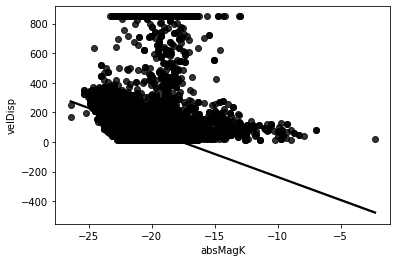

In [18]:
sns.regplot(data=temp_df[temp_df.velDisp > 1], x='absMagK', y='velDisp', color='black')

In [25]:
temp_df['logvdisp'] = temp_df.velDisp.apply(np.log10)
temp_df.logvdisp = temp_df.logvdisp.replace([np.inf, -np.inf], 0)

In [26]:
# temp_df.logvdisp
temp_df[temp_df.velDisp > 1]

ra        dec     mag_u     mag_g     mag_r     mag_i  \
1       229.065073  27.977843  18.73825  17.72186  17.11116  16.80350   
2       228.439820  27.889472  18.70973  17.65587  17.10105  16.78820   
3       228.410952  25.942005  18.88939  17.48792  16.70035  16.35189   
5       227.977870  28.034609  19.06034  17.91901  17.43973  17.09717   
6       228.063212  28.840572  19.38430  17.96141  17.28403  16.92063   
...            ...        ...       ...       ...       ...       ...   
240131  214.173172   3.741516  19.13950  17.16090  16.38967  15.99892   
240132  214.391369   3.908160  19.70588  18.27828  17.48076  17.10883   
240133  214.489911   4.234654  27.33416  18.04049  17.26530  16.93077   
240134  214.102795   4.633850  17.33032  15.93636  15.26885  14.90009   
240135  214.217041   4.696288  19.30780  17.63466  16.84627  16.46593   

           mag_z         z      zErr    velDisp  ...  logmass_upperErr  \
1       16.42904  0.085256  0.000012  102.36550  ...              0.00   
2       16.65875  0.090767  0.000011   78.06466  ...              0.00   
3       16.09914  0.085341  0.000025  107.36240  ...              0.03   
5       16.98365  0.087398  0.000008   45.68839  ...              0.00   
6       16.72977  0.085484  0.000008  109.89070  ...              0.00   
...          ...       ...       ...        ...  ...               ...   
240131  15.71356  0.053503  0.000018  166.12060  ...              0.07   
240132  16.86688  0.055281  0.000021   97.31090  ...              0.10   
240133  16.63174  0.055735  0.000024   94.89249  ...              0.00   
240134  14.73845  0.054835  0.000007  143.44960  ...              0.03   
240135  16.20480  0.054931  0.000015   98.15302  ...              0.05   

        absMagK   pca_vdisp  pca_vdisp_err  frac_ellip  frac_spiral  clid  \
1        -21.62   98.132291      31.587895       0.165        0.790     1   
2        -21.85   77.372215      20.408555       0.192        0.751     1   
3        -22.03  122.071285      30.924844       0.188        0.812     1   
5        -21.36   73.811016      21.107767       0.136        0.667     1   
6        -21.45  119.252057      33.403645       0.322        0.594     1   
...         ...         ...            ...         ...          ...   ...   
240131   -21.39  173.548822      21.356845       0.612        0.132  1800   
240132   -20.27  119.354444      33.524036       0.321        0.541  1800   
240133   -16.90  104.088602      37.735811       0.528        0.303  1800   
240134   -22.41  169.939775      37.337694       0.009        0.976  1800   
240135   -20.84  100.990148      19.901569       0.742        0.229  1800   

        member  galid  logvdisp  
1            0      1  2.010154  
2            0      2  1.892454  
3            0      3  2.030852  
5            0      5  1.659806  
6            0      6  2.040961  
...        ...    ...       ...  
240131       1     50  2.220423  
240132       0     51  1.988161  
240133       0     52  1.977232  
240134       0     53  2.156699  
240135       0     54  1.991904  

[195453 rows x 24 columns]

[(-27.0, -7.0), (1.0, 3.0)]

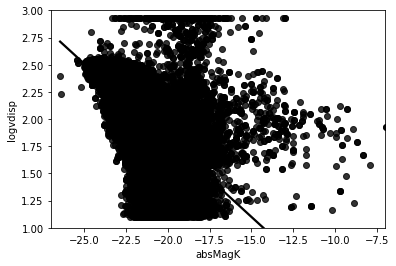

In [74]:
g = sns.regplot(data=temp_df[temp_df.velDisp > 1], x='absMagK', y='logvdisp', color='black')
g.set(xlim=(-27, -7), ylim=(1, 3))

In [31]:
import statsmodels.api as sm

X = temp_df[temp_df.velDisp > 1].absMagK
y = temp_df[temp_df.velDisp > 1].logvdisp
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logvdisp   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                 1.386e+05
Date:                Mon, 19 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:35:39   Log-Likelihood:                 38303.
No. Observations:              195453   AIC:                        -7.660e+04
Df Residuals:                  195451   BIC:                        -7.658e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0161      0.008   -124.785      0.000      -1.032      -1.000
absMagK       -0.1411      0.000   -372.266      0.000      -0.142      -0.140
==============================================================================
Omnibus:                    27798.552   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           422882.154
Skew:                           0.033   Prob(JB):                         0.00
Kurtosis:                      10.206   Cond. No.                         390.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
for idx in temp_df.index:
    if temp_df.loc[idx, 'velDisp'] <= 1:
        temp_df.loc[idx, 'velDisp'] = temp_df.loc[idx, 'pca_vdisp']

In [86]:
temp_df[temp_df['velDisp'] == 0]

ra        dec     mag_u     mag_g     mag_r     mag_i  \
2138    187.994365  27.833891  19.79210  19.56265  19.75872  20.45572   
2228    196.521699  28.787438  19.26144  17.98683  17.24483  16.95254   
2442    199.175103  31.366964  15.72718  33.32507  34.35877  33.91617   
3275    196.438958  28.871341  18.27046  16.94380  16.62802  16.45178   
3382    195.251348  28.792159  18.62807  17.95959  17.34330  17.18260   
...            ...        ...       ...       ...       ...       ...   
233419  177.776097  21.767183  18.72133  17.50802  16.81538  16.51666   
233717  176.590670  20.177477  19.12292  18.10086  17.45050  17.17928   
238493  139.288408  27.481152  18.64790  17.74568  17.41234  17.20819   
238563  135.326674  29.507619  18.51529  17.69583  17.34265  17.26818   
238836  255.200268  35.150426  20.11297  25.04937  24.75703  24.32834   

           mag_z         z      zErr  velDisp  ...  logmass_upperErr  absMagK  \
2138    21.62601  0.025208  0.000008      0.0  ...              0.00   -15.71   
2228    16.80977  0.023066  0.000062      0.0  ...              0.00   -18.35   
2442    30.85916  0.019178  0.000007      0.0  ...              0.00   -10.03   
3275    16.50854  0.026551  0.000006      0.0  ...              0.00   -19.17   
3382    17.24545  0.026597  0.000090      0.0  ...              0.00   -18.48   
...          ...       ...       ...      ...  ...               ...      ...   
233419  16.30830  0.025664  0.000017      0.0  ...              0.00   -19.06   
233717  17.18054  0.020256  0.000013      0.0  ...              0.00   -17.87   
238493  16.97659  0.023555  0.000008      0.0  ...              0.00   -18.26   
238563  17.22833  0.021671  0.000016      0.0  ...              0.00   -18.12   
238836  22.80198  0.029400  0.000019      0.0  ...              0.55   -12.59   

        pca_vdisp  pca_vdisp_err  frac_ellip  frac_spiral  clid  member  \
2138          0.0            0.0       0.098        0.353     3       0   
2228          0.0            0.0       0.347        0.549     3       0   
2442          0.0            0.0       0.017        0.932     3       0   
3275          0.0            0.0       0.171        0.268     3       0   
3382          0.0            0.0       0.265        0.511     3       1   
...           ...            ...         ...          ...   ...     ...   
233419        0.0            0.0       0.000        0.963  1713       0   
233717        0.0            0.0       0.268        0.404  1713       0   
238493        0.0            0.0       0.239        0.691  1776       0   
238563        0.0            0.0       0.050        0.642  1776       0   
238836        0.0            0.0       0.036        0.930  1779       0   

        galid  logvdisp  
2138       47      -inf  
2228      137      -inf  
2442      351      -inf  
3275     1184      -inf  
3382     1291      -inf  
...       ...       ...  
233419    275      -inf  
233717    573      -inf  
238493     70      -inf  
238563    140      -inf  
238836     46      -inf  

[73 rows x 24 columns]

In [87]:
temp_df = temp_df.drop(index=temp_df[temp_df['velDisp'] == 0].index)
temp_df

ra        dec     mag_u     mag_g     mag_r     mag_i  \
0       229.000252  27.928189  18.65716  17.67503  17.29835  17.04418   
1       229.065073  27.977843  18.73825  17.72186  17.11116  16.80350   
2       228.439820  27.889472  18.70973  17.65587  17.10105  16.78820   
3       228.410952  25.942005  18.88939  17.48792  16.70035  16.35189   
5       227.977870  28.034609  19.06034  17.91901  17.43973  17.09717   
...            ...        ...       ...       ...       ...       ...   
240131  214.173172   3.741516  19.13950  17.16090  16.38967  15.99892   
240132  214.391369   3.908160  19.70588  18.27828  17.48076  17.10883   
240133  214.489911   4.234654  27.33416  18.04049  17.26530  16.93077   
240134  214.102795   4.633850  17.33032  15.93636  15.26885  14.90009   
240135  214.217041   4.696288  19.30780  17.63466  16.84627  16.46593   

           mag_z         z      zErr    velDisp  ...  logmass_upperErr  \
0       17.01079  0.076895  0.000008  150.14679  ...              0.00   
1       16.42904  0.085256  0.000012  102.36550  ...              0.00   
2       16.65875  0.090767  0.000011   78.06466  ...              0.00   
3       16.09914  0.085341  0.000025  107.36240  ...              0.03   
5       16.98365  0.087398  0.000008   45.68839  ...              0.00   
...          ...       ...       ...        ...  ...               ...   
240131  15.71356  0.053503  0.000018  166.12060  ...              0.07   
240132  16.86688  0.055281  0.000021   97.31090  ...              0.10   
240133  16.63174  0.055735  0.000024   94.89249  ...              0.00   
240134  14.73845  0.054835  0.000007  143.44960  ...              0.03   
240135  16.20480  0.054931  0.000015   98.15302  ...              0.05   

        absMagK   pca_vdisp  pca_vdisp_err  frac_ellip  frac_spiral  clid  \
0        -21.10  150.146790      75.333053       0.033        0.878     1   
1        -21.62   98.132291      31.587895       0.165        0.790     1   
2        -21.85   77.372215      20.408555       0.192        0.751     1   
3        -22.03  122.071285      30.924844       0.188        0.812     1   
5        -21.36   73.811016      21.107767       0.136        0.667     1   
...         ...         ...            ...         ...          ...   ...   
240131   -21.39  173.548822      21.356845       0.612        0.132  1800   
240132   -20.27  119.354444      33.524036       0.321        0.541  1800   
240133   -16.90  104.088602      37.735811       0.528        0.303  1800   
240134   -22.41  169.939775      37.337694       0.009        0.976  1800   
240135   -20.84  100.990148      19.901569       0.742        0.229  1800   

        member  galid  logvdisp  
0            0      0      -inf  
1            0      1  2.010154  
2            0      2  1.892454  
3            0      3  2.030852  
5            0      5  1.659806  
...        ...    ...       ...  
240131       1     50  2.220423  
240132       0     51  1.988161  
240133       0     52  1.977232  
240134       0     53  2.156699  
240135       0     54  1.991904  

[204000 rows x 24 columns]

## 1. How to fill $M,\ M_{K},\ \sigma_{200}$

### 1-1. $\sigma$ - $M_{gal}$ relation

In [ ]:
vdisp_mean = gal_df_tot.velDisp.mean()

for idx in range(len(gal_df_tot)):
    if gal_df_tot.loc[idx, 'velDisp'] == 0:
        if gal_df_tot.loc[idx, 'pca_vdisp'] > 1:
            gal_df_tot.loc[idx, 'velDisp'] = gal_df_tot.loc[idx, 'pca_vdisp']
        else:
            gal_df_tot.loc[idx, 'velDisp'] = vdisp_mean

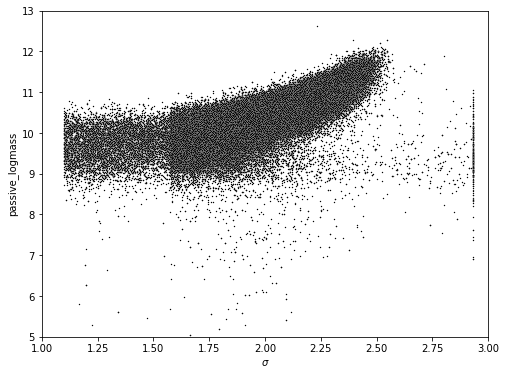

In [78]:
_, ax = plt.subplots(1,1,figsize=(8, 6))
ax = sns.scatterplot(data=temp_df,
                    x='logvdisp',
                    y='passive_logmass',
                    color='black', 
                    s=2)

ax.set_xlim(1,3)
ax.set_ylim(5,13)
ax.set_xlabel('$\sigma$')

plt.show()

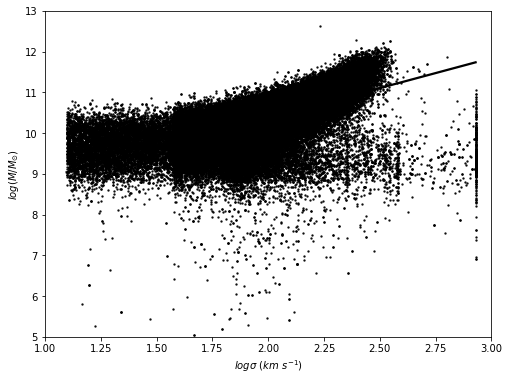

In [88]:
temp_df['logvdisp'] = temp_df.velDisp.apply(np.log10)

plt.figure(figsize=(8, 6))
g = sns.regplot(data=temp_df,
                x='logvdisp',
                y='passive_logmass',
                color='black',
                scatter_kws={'s':2})

g.set(xlim=(1,3),
      ylim=(5,13),
      xlabel='$log\sigma \ (km\ s^{-1})$',
      ylabel='$log(M/M_{\odot})$')
plt.show()

In [89]:
import statsmodels.api as sm

X = temp_df.logvdisp
y = temp_df.passive_logmass
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        passive_logmass   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                 1.558e+05
Date:                Mon, 19 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:13:47   Log-Likelihood:            -1.1894e+05
No. Observations:              204000   AIC:                         2.379e+05
Df Residuals:                  203998   BIC:                         2.379e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4248      0.008    982.219      0.000       7.410       7.440
logvdisp       1.4721      0.004    394.670      0.000       1.465       1.479
==============================================================================
Omnibus:                    96700.228   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1074173.993
Skew:                          -2.007   Prob(JB):                         0.00
Kurtosis:                      13.501   Cond. No.                         19.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion
$log(M_{gal}) = a\ log(\sigma) + b$

$a = 1.4721 \pm 0.004, \;  b = 7.4248 \pm 0.008$

$R^2 : 0.433$

- It's ambiguous to credit regression result.
- Maybe the reason is that the data is mixed all types of galaxies such as elliptical and spiral

### $\sigma - M_{gal}$ relation for elliptical galaxies

Text(1.2, 11.5, '$R^2$: 0.700\nSlope: 2.178±0.005\nIntercept: 5.946±0.011')

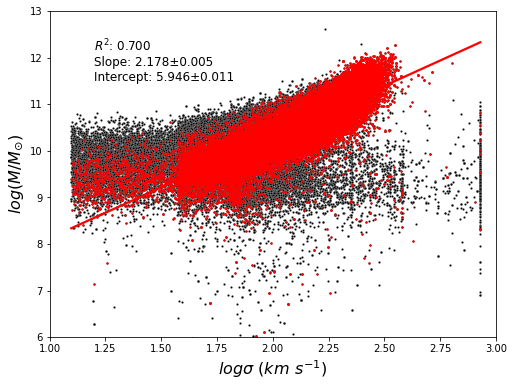

In [177]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.scatterplot(data=temp_df,
                     x='logvdisp',
                     y='passive_logmass',
                     color='black',
                     s=5)

ax = sns.regplot(data=temp_df[temp_df.frac_ellip > 0.5],
                 x='logvdisp',
                 y='passive_logmass',
                 color='red',
                 scatter_kws={'s':2})

ax.set_xlim(1,3)
ax.set_ylim(6,13)
ax.set_xlabel('$log\sigma \ (km\ s^{-1})$', fontsize=16)
ax.set_ylabel('$log(M/M_{\odot})$', fontsize=16)
ax.text(1.2, 11.5, '$R^2$: 0.700\nSlope: 2.178±0.005\nIntercept: 5.946±0.011', fontsize=12)

In [122]:
import statsmodels.api as sm

X = temp_df[temp_df.frac_ellip > 0.5].logvdisp
y = temp_df[temp_df.frac_ellip > 0.5].passive_logmass
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        passive_logmass   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                 1.677e+05
Date:                Mon, 19 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:09:00   Log-Likelihood:                -17019.
No. Observations:               71774   AIC:                         3.404e+04
Df Residuals:                   71772   BIC:                         3.406e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9458      0.011    519.982      0.000       5.923       5.968
logvdisp       2.1781      0.005    409.569      0.000       2.168       2.189
==============================================================================
Omnibus:                    29004.949   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           587204.539
Skew:                          -1.450   Prob(JB):                         0.00
Kurtosis:                      16.709   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion
$log(M_{gal}) = a\ log(\sigma) + b$

$a = 2.1781 \pm 0.005, \;  b = 	5.9458 \pm 0.011$

$R^2 : 0.7$

This result $M$~ $\sigma^{2.1781}$ is close to $M$~ $\sigma^2$ in virial theorom.

In [ ]:
def predict_logmass(velDisp):
    a = 2.1781
    b = 5.9458
    return a * np.log10(velDisp) + b

### $M_{K} - \sigma$ relationship

Text(-26.65, 1.4, '$R^2$: 0.648\nSlope: −0.125\nIntercept: \n−0.54±0.013')

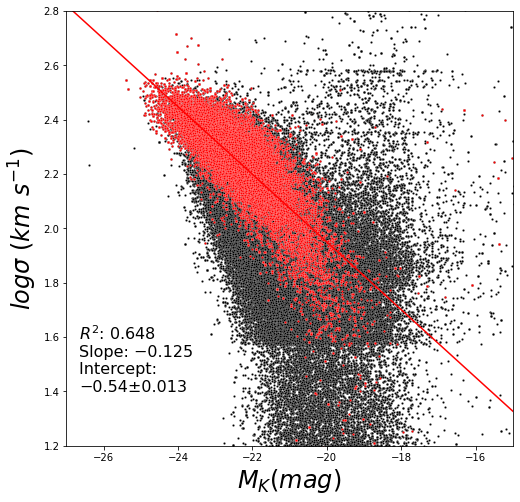

In [570]:
_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = sns.scatterplot(data=temp_df,
                     x='absMagK',
                     y='logvdisp',
                     color='black',
                     s=5, alpha=1)

ax = sns.scatterplot(data=temp_df[temp_df.frac_ellip > 0.8],
                     x='absMagK',
                     y='logvdisp',
                     color='red',
                     s=5, alpha=1)

x = np.linspace(-27, -15, 121)
y = (-0.1245) * x - 0.5401 * np.ones(121)
ax.plot(x, y, color='red')
ax.set_xlim(-27,-15)
ax.set_ylim(1.2,2.8)
ax.set_xlabel('$M_{K} (mag)$', fontsize=24)
ax.set_ylabel('$log\sigma \ (km\ s^{-1})$', fontsize=24)
ax.text(-26.65, 1.4, '$R^2$: 0.648\nSlope: −0.125\nIntercept: \n−0.54±0.013', fontsize=16)

In [94]:
import statsmodels.api as sm

X = temp_df.absMagK
y = temp_df.logvdisp
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logvdisp   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                 1.107e+05
Date:                Mon, 19 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:18:21   Log-Likelihood:                 31681.
No. Observations:              204000   AIC:                        -6.336e+04
Df Residuals:                  203998   BIC:                        -6.334e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6104      0.008    -77.368      0.000      -0.626      -0.595
absMagK       -0.1226      0.000   -332.735      0.000      -0.123      -0.122
==============================================================================
Omnibus:                    23831.429   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           250604.915
Skew:                          -0.043   Prob(JB):                         0.00
Kurtosis:                       8.429   Cond. No.                         369.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
X = temp_df[temp_df.frac_ellip > 0.8].absMagK
y = temp_df[temp_df.frac_ellip > 0.8].logvdisp
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logvdisp   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                 4.294e+04
Date:                Mon, 19 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:27:29   Log-Likelihood:                 21083.
No. Observations:               23624   AIC:                        -4.216e+04
Df Residuals:                   23622   BIC:                        -4.215e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5401      0.013    -40.256      0.000      -0.566      -0.514
absMagK       -0.1245      0.001   -207.225      0.000      -0.126      -0.123
==============================================================================
Omnibus:                     4773.319   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           166939.781
Skew:                          -0.106   Prob(JB):                         0.00
Kurtosis:                      16.021   Cond. No.                         465.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion
$log(\sigma) = a\ M_{K} + b$

$a = -0.125, \;  b = -0.5401 \pm 0.013$

$R^2 : 0.645$

This result $L$~ $\sigma^{3.21}$ is close to $L$~ $\sigma^4$ in Faber-Jackson relation for elliptical galaxies.

In [120]:
1 / 2.5 / 0.11

3.6363636363636367

In [105]:
1 / 2.5 / 0.1246

3.2102728731942216

In [106]:
1 / 2.5 / 0.1245

3.21285140562249

### $M_{i} $ - $M_{K}$ relationship ($i\ =\ u,g,r,i,z$)

#### Method to measure absolute magnitude

1) $d(Mpc) = \frac{v_{r}(z)}{H(z)}$

2) $m-M=5logd + 25\; where\; d(Mpc)$

3) $H(z) = 100h(z)$

4) $h(z) = h_{0}\sqrt{0.3(1+z)^3+0.7}$

5) $v_{r}(z) = \frac{(1+z)^2 - 1}{(1+z)^2 + 1}c$

=> $M = m - 15 -5log(\frac{v_{r}(z)}{h(z)})$

In [123]:
def radial_v(z):
    # calculating relativistic radial velocity with redshift
    return c * ((z+1)**2 - 1)/((z+1)**2 + 1)

def dimless_h(z, h_0=0.7):
    # Calculating dimesionless hubble constant, h(z)
    # According to the GalWCat19 paper,
    # Omega(r, m, k, gamma) = (0, 0.3, 0, 0.7)
    # default: h_0 = 0.7
    return h_0 * np.sqrt(0.3*(1 + z)**3 + 0.7)

def absMag(mag, z, h_0):
    v_r = radial_v(z)
    h = dimless_h(z, h_0)
    return mag - 15 - 5 * np.log10(v_r/h)

In [124]:
maglist = ['mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z']
absmaglist = ['absmag_u', 'absmag_g', 'absmag_r', 'absmag_i', 'absmag_z']

for mag, absmag in zip(maglist, absmaglist):
    temp_df[absmag] = temp_df.apply(lambda x: absMag(x[mag], cls_info.loc[x.clid, 'z'], 0.7),
                                    axis=1)

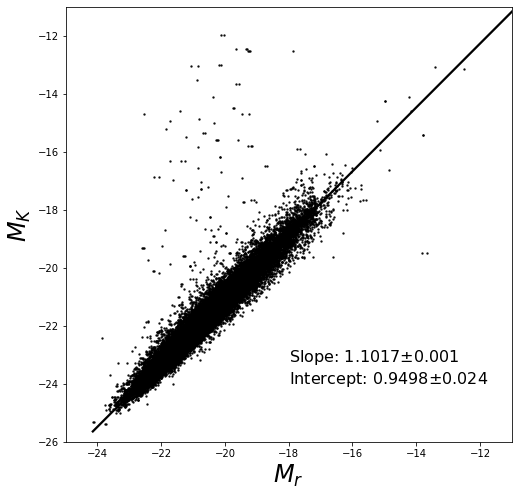

In [603]:
_, ax = plt.subplots(1,1, figsize=(8, 8))
ax = sns.regplot(data=temp_df[temp_df.frac_ellip > 0.5], 
                 x='absmag_r', 
                 y='absMagK', 
                 color='black',
                 scatter_kws={'s':2})
ax.set_xlabel('$M_r$', fontsize=24)
ax.set_ylabel('$M_K$', fontsize=24)
ax.text(-18, -24, 'Slope: 1.1017$\pm$0.001\nIntercept: 0.9498$\pm$0.024', fontsize=16)
ax.set_xlim(-25, -11)
ax.set_ylim(-26, -11)
plt.show()

In [144]:
import statsmodels.api as sm

X = temp_df[temp_df.frac_ellip > 0.5].absmag_r
y = temp_df[temp_df.frac_ellip > 0.5].absMagK
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                absMagK   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 8.785e+05
Date:                Tue, 20 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:29:31   Log-Likelihood:                -21096.
No. Observations:               71774   AIC:                         4.220e+04
Df Residuals:                   71772   BIC:                         4.222e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9498      0.024     39.188      0.000       0.902       0.997
absmag_r       1.1017      0.001    937.260      0.000       1.099       1.104
==============================================================================
Omnibus:                   102802.368   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        100968983.430
Skew:                           8.151   Prob(JB):                         0.00
Kurtosis:                     186.021   Cond. No.                         413.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
temp_df[['absMagK'] + absmaglist]

In [ ]:
temp_df['g-r'] = temp_df.mag_g - temp_df.mag_r
temp_df['r-i'] = temp_df.mag_r - temp_df.mag_i
temp_df[['absMagK', 'g-r', 'r-i'] + absmaglist]

### Conclusion

$ M_K = 1.1017\;M_r + 0.9498$

In [ ]:
g = sns.scatterplot(data=temp_df[temp_df.frac_ellip > 0.8],
                    x='absmag_i',
                    y='absMagK',
                    hue='frac_ellip',
                    palette='viridis')
g.set(xlim=(-25,-10), ylim=(5,13))

In [ ]:
g = sns.scatterplot(data=temp_df[temp_df.frac_ellip > 0.8][temp_df.logvdisp > 2],
                    x='absmag_i',
                    y='passive_logmass',
                    hue='frac_ellip',
                    palette='viridis')
g.set(xlim=(-25,-10), ylim=(5,13))

In [ ]:
g = sns.scatterplot(data=temp_df[temp_df.frac_spiral > 0.8],
                    x='absmag_r',
                    y='passive_logmass',
                    hue='frac_spiral',
                    palette='viridis')
g.set(xlim=(-25,-10), ylim=(5,13))

In [ ]:
g = sns.regplot(data=temp_df,
                x='absMagK',
                y='passive_logmass',
                color='black',
                scatter_kws={'s':2})
g.set(xlim=(-25,-10), ylim=(5,13))

In [ ]:
g = sns.regplot(data=temp_df[temp_df.frac_ellip > 0.5],
                x='absmag_i',
                y='passive_logmass',
                color='black',
                scatter_kws={'s':2})
g.set(xlim=(-25,-10), ylim=(5,13))

Text(0.5, 0, '$M_K$')

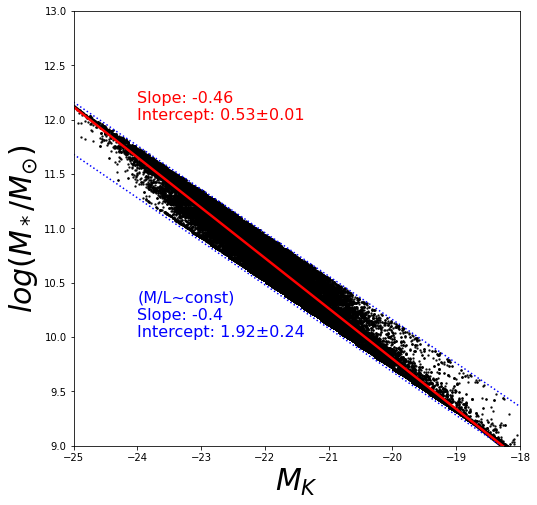

In [604]:
_, ax = plt.subplots(1,1, figsize=(8, 8))
ax = sns.regplot(data=temp_df[temp_df.frac_ellip > 0.5], 
                 x='absmag_r', 
                 y='absMagK', 
                 color='black',
                 scatter_kws={'s':2})
ax.set_xlabel('$M_r$', fontsize=24)
ax.set_ylabel('$M_K$', fontsize=24)
ax.text(-18, -24, 'Slope: 1.1017$\pm$0.001\nIntercept: 0.9498$\pm$0.024', fontsize=16)
ax.set_xlim(-25, -11)
ax.set_ylim(-26, -11)



ax = sns.regplot(data=temp_df[temp_df.frac_ellip > 0.5][temp_df.absMagK < -18],
                 x='absMagK',
                 y='passive_logmass',
                 color='black',
                 scatter_kws={'s':2})

x_mag = np.linspace(-25, -18, 100)
y_mass1 = -0.4 * x_mag + 2.16 * np.ones(100)
y_mass2 = -0.4 * x_mag + 1.68 * np.ones(100)
y_mass3 = -0.4633 * x_mag + 0.5340 * np.ones(100)
font1 = {'color':  'black',
         'weight': 'normal',
         'size': 14}


ax.plot(x_mag, y_mass1, ':', color='blue')
ax.plot(x_mag, y_mass2, ':', color='blue')
ax.plot(x_mag, y_mass3, linewidth=2.5, color='red')
ax.text(-24, 12, 'Slope: -0.46\nIntercept: 0.53±0.01', color='red', fontsize=16)
ax.text(-24, 10, '(M/L~const)\nSlope: -0.4\nIntercept: 1.92±0.24', color='blue', fontsize=16)

ax.set_xlim(-25,-18)
ax.set_ylim(9,13)
ax.set_ylabel('$log(M_*/M_{\odot})$', fontsize=30)
ax.set_xlabel('$M_K$', fontsize=30)

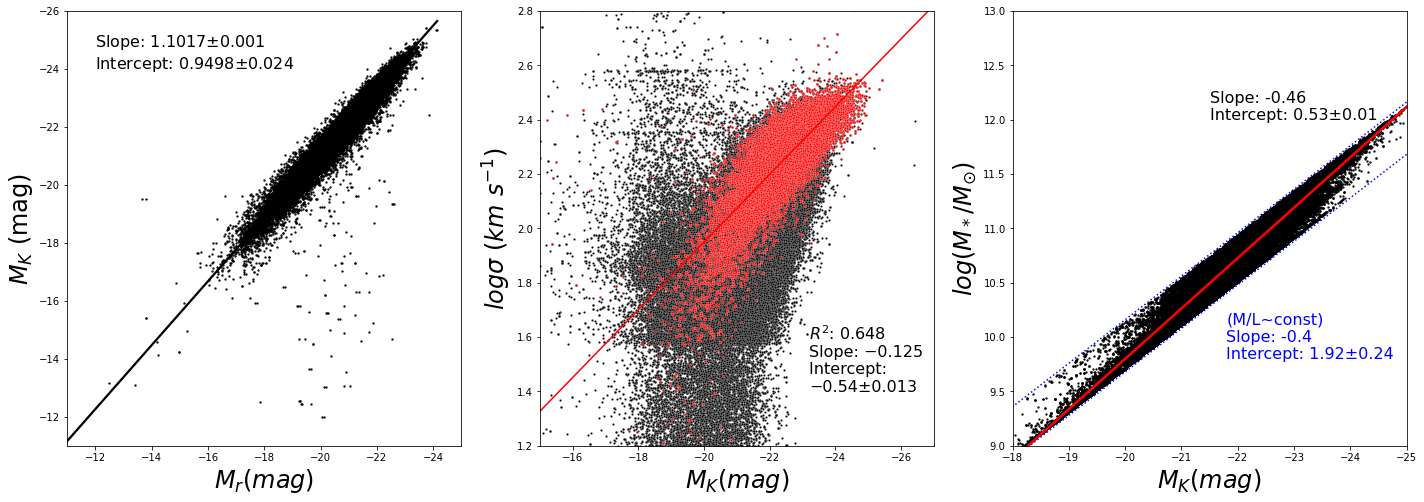

In [701]:
_, ax = plt.subplots(1,3, figsize=(24, 8))
sns.regplot(data=temp_df[temp_df.frac_ellip > 0.5], 
            x='absmag_r', 
            y='absMagK', 
            color='black',
            scatter_kws={'s':2}, 
            ax=ax[0])
ax[0].set_xlabel('$M_r (mag)$', fontsize=24)
ax[0].set_ylabel('$M_K$ (mag)', fontsize=24)
ax[0].text(-12, -24, 'Slope: 1.1017$\pm$0.001\nIntercept: 0.9498$\pm$0.024', fontsize=16)
ax[0].set_xlim(-11, -25)
ax[0].set_ylim(-11, -26)
##-----------------------------------------------------------------------------------##

sns.scatterplot(data=temp_df,
                x='absMagK',
                y='logvdisp',
                color='black',
                s=5, alpha=1, 
                ax=ax[1])

sns.scatterplot(data=temp_df[temp_df.frac_ellip > 0.8],
                x='absMagK',
                y='logvdisp',
                color='red',
                s=5, alpha=1, 
                ax=ax[1])

x = np.linspace(-27, -15, 121)
y = (-0.1245) * x - 0.5401 * np.ones(121)
ax[1].plot(x, y, color='red')
ax[1].set_xlim(-15, -27)
ax[1].set_ylim(1.2,2.8)
ax[1].set_xlabel('$M_{K} (mag)$', fontsize=24)
ax[1].set_ylabel('$log\sigma \ (km\ s^{-1})$', fontsize=24)
ax[1].text(-23.2, 1.4, '$R^2$: 0.648\nSlope: −0.125\nIntercept: \n−0.54±0.013', fontsize=16)
##-----------------------------------------------------------------------------------##
sns.regplot(data=temp_df[temp_df.frac_ellip > 0.5],
            x='absMagK',
            y='passive_logmass',
            color='black',
            scatter_kws={'s':2},
            ax=ax[2])

x_mag = np.linspace(-25, -18, 100)
y_mass1 = -0.4 * x_mag + 2.16 * np.ones(100)
y_mass2 = -0.4 * x_mag + 1.68 * np.ones(100)
y_mass3 = -0.4633 * x_mag + 0.5340 * np.ones(100)

ax[2].plot(x_mag, y_mass1, ':', color='blue')
ax[2].plot(x_mag, y_mass2, ':', color='blue')
ax[2].plot(x_mag, y_mass3, linewidth=2.5, color='red')
ax[2].text(-21.5, 12, 'Slope: -0.46\nIntercept: 0.53±0.01', fontsize=16)
ax[2].text(-21.8, 9.8, '(M/L~const)\nSlope: -0.4\nIntercept: 1.92±0.24', color='blue', fontsize=16)

ax[2].set_xlim(-18,-25)
ax[2].set_ylim(9,13)
ax[2].set_ylabel('$log(M_*/M_{\odot})$', fontsize=24)
ax[2].set_xlabel('$M_K (mag)$', fontsize=24)

plt.show()

In [550]:
elliptical = temp_df[temp_df.frac_ellip > 0.5]

X = elliptical[['absMagK']]
y = elliptical.passive_logmass
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        passive_logmass   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 1.491e+06
Date:                Tue, 20 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:49:03   Log-Likelihood:                 50287.
No. Observations:               71774   AIC:                        -1.006e+05
Df Residuals:                   71772   BIC:                        -1.006e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5340      0.008     64.645      0.000       0.518       0.550
absMagK       -0.4633      0.000  -1221.010      0.000      -0.464      -0.463
==============================================================================
Omnibus:                      151.897   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.996
Skew:                           0.091   Prob(JB):                     1.98e-32
Kurtosis:                       2.875   Cond. No.                         402.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3. M-L relation

$ M_{k, \odot} = 3.27$ (Willmer. 2018)

$ M_{k} - M_{k, \odot} = - 2.5 log(L/L_{\odot}) = -2.5logL$

$ M_{k} = 3.27 -2.5logL $

$ logL = -0.4*M_{k} + 1.31 $

$ M/L = const$ 

When $M, L$ in unit of $M_{\odot}, L_{\odot} $

$ log(M/L) = a $

$\therefore LogM = logL + a$

$\quad\quad\quad\ = -0.4*M_k + 1.31 + a$

$ Then, 0.37 \leqq a \leqq 0.85 $

$ \therefore 2.34 \leqq M/L \leqq 7.08$

### Linear Regression result : M/L ~ 4

In [155]:
import statsmodels.api as sm



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        passive_logmass   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                 3.746e+06
Date:                Tue, 20 Dec 2022   Prob (F-statistic):               0.00
Time:                        02:40:27   Log-Likelihood:             1.2546e+05
No. Observations:              204000   AIC:                        -2.509e+05
Df Residuals:                  203998   BIC:                        -2.509e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7578      0.005    152.115      0.000       0.748       0.768
absMagK       -0.4503      0.000  -1935.506      0.000      -0.451      -0.450
==============================================================================
Omnibus:                    14697.084   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18126.069
Skew:                           0.729   Prob(JB):                         0.00
Kurtosis:                       2.920   Cond. No.                         369.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X = temp_df[temp_df.frac_ellip > 0.5].absmag_i
y = temp_df[temp_df.frac_ellip > 0.5].passive_logmass
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

$log_{10}M_{gal} = a\ M_{i} + b$

$a = -0.4875 \pm 0.001, \;  b = 0.3785 \pm 0.014$

$R^2 : 0.878$

In [ ]:
def absMag(mag, z, h_0):
    v_r = radial_v(z)
    h = dimless_h(z, h_0)
    return mag - 15 - 5 * np.log10(v_r/h)

def predict_logmass(mag_i, z, h_0):
    absMag_i = absMag(mag_i, z, h_0)
    a = -0.4875
    b = 0.3785
    return a * absMag_i + b

In [ ]:
gal_df_tot.passive_logmass.isnull().sum()

In [ ]:
mass_pred = gal_df_tot.apply(lambda x: predict_logmass(x[mag], cls_info.loc[x.clid, 'z'], 0.7),
                             axis=1)
gal_df_tot.passive_logmass = np.where(gal_df_tot.passive_logmass.isnull(),
                                      mass_pred,
                                      gal_df_tot.passive_logmass)

gal_df_tot.passive_logmass.isnull().sum()

In [ ]:
gal_df_tot.passive_logmass

## $\sigma$ - $M_{K}$ relation

In [ ]:
vdisp_mean = gal_df_tot.velDisp.mean()

for idx in range(len(gal_df_tot)):
    if gal_df_tot.loc[idx, 'velDisp'] == 0:
        if gal_df_tot.loc[idx, 'pca_vdisp'] > 1:
            gal_df_tot.loc[idx, 'velDisp'] = gal_df_tot.loc[idx, 'pca_vdisp']
        else:
            gal_df_tot.loc[idx, 'velDisp'] = vdisp_mean

In [ ]:
gal_df_tot.velDisp

In [ ]:
_, ax = plt.subplots(1,1, figsize=(8, 8))
ax = sns.regplot(data=temp_df[temp_df.frac_ellip > 0.5], 
                 x='absMagK', 
                 y='velDisp', 
                 color='black',
                 scatter_kws={'s':2})
ax.set_xlabel('$M_r$', fontsize=16)
ax.set_ylabel('$M_K$', fontsize=16)
ax.text(-17, -24, 'Slope: 1.1017$\pm$0.001\nIntercept: 0.9498$\pm$0.024', fontsize=12)
ax.set_xlim(-25, -11)
ax.set_ylim(-26, -11)
plt.show()

## EDA

### Position Diagram

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

_, ax = plt.subplots(20, 5, figsize=(20, 80))
for row in range(20):
    for col in range(5):
        num = 5 * row + col
        sns.scatterplot(data=gal_df_ls[num], x='ra', y='dec',
                        hue='z', palette='viridis', ax=ax[row][col])
        ax[row][col].scatter(cls_info.loc[num+1, 'ra'],
                             cls_info.loc[num+1, 'dec'],
                             marker='^', color='red', s=50)
        ax[row][col].set_title(f"Cluster No.{num + 1}")
plt.show()

In [ ]:
index_ls = [15,32,43,60,280,305,387,394,398,489,841,846,887,910,961,991]
_, ax = plt.subplots(4, 4, figsize=(20, 20))

for row in range(4):
    for col in range(4):
        idx = index_ls[4 * row + col]
        sns.scatterplot(data=gal_df_ls[idx-1], x='ra', y='dec',
                        hue='z', palette='viridis', ax=ax[row][col])
        ax[row][col].scatter(cls_info.loc[idx, 'ra'],
                             cls_info.loc[idx, 'dec'],
                             marker='^', color='red', s=50)
        ax[row][col].set_title(f"Cluster No.{idx}")
plt.show()

In [ ]:
_, ax = plt.subplots(20, 5, figsize=(20, 80))

for row in range(20):
    for col in range(5):
        num = 5 * row + col
        sns.boxplot(data=gal_df_ls[num], x='mag_r', color='black', ax=ax[row][col])
        ax[row][col].set_title(f"Cluster No.{num + 1}")
plt.show()

In [36]:
def circular_v(mass, radius):
    # Units
    # 1) mass : solar mass
    # 2) radius : Mpc
    return np.sqrt(G * mass / radius)

def peculiar_z(z_obs, z_cls, absolute=False):
    # Calculating peculiar redshift
    z_pec = (z_obs - z_cls) / (1 + z_cls)
    if absolute:
        z_pec = abs(z_pec)
    return z_pec

def peculiar_v(z_obs, z_cls, absolute=False):
    # Calculating relativisitic peculiar velocity of radial direction
    z_pec = peculiar_z(z_obs, z_cls, absolute)
    return radial_v(z_pec)

def projected_radius(point, center, z_cls, h_0=1):
    dist = comv_dist(z_cls, h_0)
    return dist * np.sin(angular_dist(point, center) * deg2rad)

In [37]:


v_c = circular_v(cls_info['M_200'], cls_info['r_200'])
cls_info['v_c'] = v_c
cls_info

N_gal         ra        dec         z   comv_dist       v_rad     r_500  \
1       166  230.65973  27.743846  0.073177  21137.1930  215.714310  1.151608   
2        61  227.55402  33.498096  0.113908  32215.0730  332.547940  0.995621   
3       670  194.93502  27.912461  0.023372   6924.9620   69.697942  1.017135   
4       149  258.20851  64.052953  0.080997  23301.8680  238.327350  0.945980   
5        75  209.83093  27.968947  0.075065  21661.5240  221.182270  0.990827   
...     ...        ...        ...       ...         ...         ...       ...   
1796     11  219.29860  41.137525  0.018229   5415.0324   54.423323  0.314627   
1797      9  244.13139  17.296896  0.083403  23964.1060  245.265940  0.359730   
1798     12  195.66504  62.490557  0.076106  21950.0540  224.193750  0.335472   
1799     30  122.19122  38.880306  0.040514  11899.8630  120.340620  0.360137   
1800     13  214.03540   3.680044  0.055020  16041.3390  162.879800  0.336119   

      N_500   sigma_500         M_500  ...         M_100     r_005  N_005  \
1       123  1132.33920  9.506491e+14  ...  1.689758e+15  7.794941    446   
2        45  1007.64840  6.394636e+14  ...  1.104408e+15  6.618137    143   
3       485   992.56078  6.248669e+14  ...  1.081975e+15  6.772127   1389   
4       103   863.31423  5.309468e+14  ...  9.705232e+14  6.516373    314   
5        56   858.50327  6.065896e+14  ...  8.778047e+14  5.876928    189   
...     ...         ...           ...  ...           ...       ...    ...   
1796      5   360.63167  1.840703e+13  ...  5.847822e+13  3.039897     65   
1797      6   294.11717  2.926546e+13  ...  4.490443e+13  2.217003     15   
1798      7   368.78647  2.356717e+13  ...  5.073969e+13  2.557282     34   
1799     24   303.70400  2.818272e+13  ...  4.566585e+13  2.298817     52   
1800      8   292.17797  2.322821e+13  ...  5.090191e+13  2.590150     34   

      sigma_005         M_005   R_s           M_s  concentration  r_005/r_200  \
1     706.55424  3.242931e+15  0.41  3.060947e+14       4.289865     4.431853   
2     695.01505  2.066015e+15  0.32  1.879991e+14       4.722965     4.378961   
3     750.50479  2.028706e+15  0.33  1.852209e+14       4.681364     4.383680   
4     683.99230  1.909044e+15  0.37  1.864585e+14       3.928135     4.483507   
5     632.52100  1.392339e+15  0.14  9.659857e+13      10.349945     4.055873   
...         ...           ...   ...           ...            ...          ...   
1796  189.87618  1.826270e+14  0.45  2.996108e+13       1.208494     5.589871   
1797  259.43799  7.535574e+13  0.07  5.782326e+12       7.608282     4.162762   
1798  240.86964  1.148334e+14  0.21  1.340652e+13       2.541560     4.791363   
1799  299.56166  8.062803e+13  0.09  6.722908e+12       5.992770     4.262205   
1800  226.40749  1.169240e+14  0.22  1.389197e+13       2.439910     4.825345   

              v_c  
1     1820.083430  
2     1595.666183  
3     1561.429528  
4     1509.737343  
5     1500.814827  
...           ...  
1796   548.359515  
1797   553.869739  
1798   553.095183  
1799   549.503823  
1800   550.649316  

[1800 rows x 27 columns]

In [38]:
for idx in range(len(gal_df_ls)):
    gal_df = gal_df_ls[idx]
    v_p = peculiar_v(gal_df['z'],
                     cls_info.loc[idx+1, 'z'])
    
    point = (gal_df['ra'], gal_df['dec'])
    center = (cls_info.loc[idx+1, 'ra'], cls_info.loc[idx+1, 'dec'])
    R = projected_radius(point, center,
                         cls_info.loc[idx+1, 'z'])
    
    gal_df['v_pec'] = v_p
    gal_df['v_pec/sigma_200'] = v_p / cls_info.loc[idx+1, 'sigma_200']
    gal_df['v_pec/v_c'] = v_p / cls_info.loc[idx+1, 'v_c']
    gal_df['R_p'] = R
    gal_df['R_p/r_200'] = R / cls_info.loc[idx+1, 'r_200']
    
gal_df_ls[2]

objid          ra        dec           l          b  \
0     1237667448879382623  190.106312  26.010573  236.726437  87.295831   
1     1237667448879382616  190.094754  25.979773  237.220701  87.273286   
2     1237665025981874291  193.482564  35.399530  119.406710  81.711777   
3     1237665025981939726  193.693303  35.404962  118.223038  81.692894   
4     1237667447807475811  194.802629  25.003935  342.770411  87.250607   
...                   ...         ...        ...         ...        ...   
2684  1237667911669842295  192.203537  24.999164  287.316852  87.790782   
2685  1237667911669973173  192.525085  25.022197  294.740708  87.872529   
2686  1237667917034422396  193.542135  21.000715  308.882085  83.840793   
2687  1237667917036126326  197.576724  20.688171  337.725530  82.251441   
2688  1237668299282776069  197.003476  20.611481  333.973945  82.463138   

         mag_u     mag_g     mag_r     mag_i     mag_z  ...  pca_vdisp_err  \
0     19.47279  18.20222  17.85371  17.68863  17.79467  ...      31.097733   
1     18.43274  17.21557  16.69702  16.51296  16.28568  ...      15.698454   
2     18.07047  17.17382  16.90129  16.73626  16.66437  ...      22.224004   
3     17.04089  15.89638  15.22128  14.88547  14.63096  ...      32.852828   
4     18.71188  17.55696  17.18297  16.98836  16.86872  ...      15.863817   
...        ...       ...       ...       ...       ...  ...            ...   
2684  18.67459  17.88709  17.41840  16.99464  17.03335  ...      88.103108   
2685  16.15503  15.14304  14.75258  14.56436  14.46030  ...      16.972755   
2686  17.38243  16.51376  16.19849  16.03167  15.99054  ...      37.895092   
2687  23.19589  21.52144  20.90873  21.36425  22.73740  ...       0.000000   
2688  17.18837  15.98608  15.53425  15.26811  15.12484  ...      32.502502   

      frac_ellip  frac_spiral  clid  member        v_pec  v_pec/sigma_200  \
0            NaN          NaN     3       0  -434.396748        -0.465790   
1          0.010        0.990     3       0  -426.203041        -0.457004   
2          0.182        0.641     3       0  2804.890721         3.007593   
3          0.103        0.690     3       0  4880.564494         5.233271   
4          0.087        0.852     3       0   730.158951         0.782926   
...          ...          ...   ...     ...          ...              ...   
2684       0.046        0.657     3       0  -186.108985        -0.199559   
2685       0.000        0.984     3       0  -546.446756        -0.585937   
2686       0.087        0.913     3       0   -60.588749        -0.064967   
2687       0.057        0.852     3       0 -3913.179559        -4.195976   
2688       0.680        0.140     3       0  5215.493255         5.592404   

      v_pec/v_c       R_p  R_p/r_200  
0     -0.278205  6.303497   4.080330  
1     -0.272957  6.330236   4.097638  
2      1.796361  9.249183   5.987108  
3      3.125703  9.210907   5.962331  
4      0.467622  3.540237   2.291638  
...         ...       ...        ...  
2684  -0.119191  4.853057   3.141442  
2685  -0.349966  4.573649   2.960578  
2686  -0.038803  8.554447   5.537396  
2687  -2.506152  9.326180   6.036948  
2688   3.340204  9.202089   5.956623  

[2689 rows x 30 columns]

In [ ]:
def truncate(number, digits) -> float:
    # truncate(1.632, 1) == 1.6
    # truncate(1.632, 2) == 1.63
    # truncate(-1.632, 2) == -1.63
    nbDecimals = len(str(number).split('.')[1])
    if nbDecimals <= digits:
        return number
    n = str(number).split('.')[0]
    f = str(number).split('.')[1][:digits]
    return float(n + '.' + f)

def ceil(number, digits) -> float:
    # ceil(1.632, 1) == 1.7
    # ceil(1.632, 2) == 1.64
    # ceil(-1.632, 2) == -1.64
    stepper = 10.0 ** (-digits)
    nbDecimals = len(str(number).split('.')[1])
    if nbDecimals <= digits:
        return number
    n = str(number).split('.')[0]
    f = int(str(number).split('.')[1][:digits]) + 1
    return float(n + '.' + str(f))

In [ ]:
print(ceil(gal_df_ls[0]['v_pec/v_c'].min(), 1),
      truncate(gal_df_ls[0]['v_pec/v_c'].max(), 1))

In [ ]:
print(gal_df_ls[0]['v_pec/v_c'].min(), gal_df_ls[0]['v_pec/v_c'].max())

### Gaussian Function

In [ ]:
from astropy.modeling.functional_models import Gaussian1D

func = Gaussian1D(3, 0, 0.3)
r = np.arange(-1, 1, .01)

plt.figure()
plt.plot(r, func(r), color='0', lw=2)
plt.show()

### NFW Profile

$(\frac{v}{v_{200}})^2=\frac{1}{x}\frac{\ln(1+cx)-(cx)/(1+cx)}{\ln(1+c)-c/(1+c)}$

where $x\equiv r/r_{200},\ v_{200} = \sqrt{\frac{GM_{200}}{r_{200}}}$

In [44]:
class NFW:
    def __init__(self, concentration, r_s, M_s, overdensity=200, h=1):
        self.h = h
        self.rho_c = 2.7754e11 * (self.h**2)
        self.delta = overdensity
        self.rho_delta = self.delta * self.rho_c
        self.concentration = concentration
        self.r_delta = concentration * r_s
        self.r_s = r_s
        self.M_s = M_s
        self.c = 299792.458 # speed of light
        self.G = 4.30091727e-9 # Mpc * M_solar^(-1) * (km/s)^2
        
    def density(self, r):
        x = r / self.r_s
        return self.rho_delta / (x * (1+x)**2)
    
    def A_NFW(self, y):
        return np.log(1.0 + y) - (y / (1.0 + y))
    
    def Mass(self, r):
        """
        ratio: ratio of r / r_200
        """
        x = r * self.concentration # convert r/r_200 to r/r_s
        return M_s * self.A_NFW(x) / self.A_NFW(1)
    
    def r_max(self):
        return 2.16258 * self.r_s
    
    def v_circ(self, ratio):
        """
        ratio: ratio of r / r_200
        """
        x = ratio
        r_vir = self.r_s * self.concentration
        v_vir = np.sqrt(self.G * self.Mass(r_vir) / r_vir)
        ratio = self.A_NFW(self.concentration * x) / self.A_NFW(self.concentration)
        return v_vir * np.sqrt(ratio / x)

In [46]:
concentration, r_s, M_s = cls_info.loc[1, ['concentration', 'R_s', 'M_s']].tolist()
print(concentration, r_s, M_s)
nfw = NFW(concentration, r_s, M_s)
r_r200 = np.linspace(0.1, 6, 600)
M = nfw.Mass(r)
v_cp = nfw.v_circ(r_r200) / cls_info.loc[1, 'v_c']
v_cm = -v_cp

4.2898652 0.41 306094730000000.0


### $v_{vir}$ calculating

In [522]:
cls_info.columns

Index(['N_gal', 'ra', 'dec', 'z', 'comv_dist', 'v_rad', 'r_500', 'N_500',
       'sigma_500', 'M_500', 'r_200', 'N_200', 'sigma_200', 'M_200', 'r_100',
       'N_100', 'sigma_100', 'M_100', 'r_005', 'N_005', 'sigma_005', 'M_005',
       'R_s', 'M_s', 'concentration', 'r_005/r_200', 'v_c'],
      dtype='object')

In [523]:
def make_v_c(concentration, R_s, M_s):
    nfw = NFW(concentration, R_s, M_s)
    return nfw.v_circ(1)

cls_info['v_c'] = cls_info.apply(lambda x: make_v_c(x.concentration, x.R_s, x.M_s), axis=1)

In [525]:
for idx in cls_info.index:
    gal_df_tot.loc[gal_df_tot.clid == idx, 'v_pec/v_c'] = gal_df_tot.loc[gal_df_tot.clid == idx, 'v_pec'] / cls_info.loc[idx, 'v_c']

gal_df_tot['v_pec/v_c']

0         1.276380
1         4.129962
2         5.998696
3         4.158675
4        -6.581800
            ...   
240131   -0.634068
240132    0.108993
240133    0.298749
240134   -0.077014
240135   -0.036886
Name: v_pec/v_c, Length: 240136, dtype: float64

In [ ]:
print(nfw.A_NFW(1))
print(nfw.A_NFW(1))
print(nfw.A_NFW(concentration))

In [47]:
print(nfw.Mass(cls_info.loc[1, 'R_s']))
print(nfw.Mass(cls_info.loc[1, 'r_200']))
print(cls_info.loc[1, 'M_s'])
print(cls_info.loc[1, 'M_200'])

597907816645788.9
2000611702804772.2
306094730000000.0
1354718300000000.0


In [48]:
print(nfw.Mass(cls_info.loc[1, 'R_s']))
print(nfw.Mass(cls_info.loc[1, 'r_200']))
print(cls_info.loc[1, 'M_s'])
print(cls_info.loc[1, 'M_200'])

597907816645788.9
2000611702804772.2
306094730000000.0
1354718300000000.0


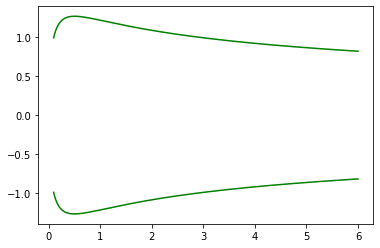

In [49]:
plt.figure()
plt.plot(r, v_cp, color='g')
plt.plot(r, v_cm, color='g')
plt.show()

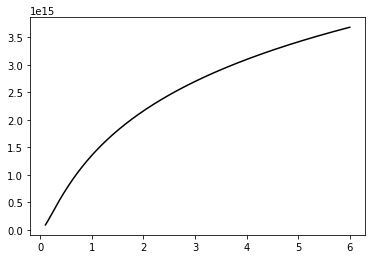

In [50]:
plt.figure()
plt.plot(r, M, color='black')
plt.show()

In [526]:
def R_v_diagram(clid, ax):
    gal_df = gal_df_tot.loc[gal_df_tot.clid == clid, :]
    colors = gal_df.member.map({0:'gray', 1:'black'}).values
    sns.scatterplot(data=gal_df,
                    x='R_p/r_200', y='v_pec/v_c',
                    color=colors, s=10,
                    ax=ax)

    N = 100
    v_max = gal_df['v_pec/v_c'].apply(abs).max()
    r_max = gal_df['R_p/r_200'].max()

    concentration, r_s, M_s = cls_info.loc[clid,
                                           ['concentration', 'R_s', 'M_s']].tolist()
    nfw = NFW(concentration, r_s, M_s)
    print(nfw.v_circ(1), cls_info.loc[clid, 'v_c'])

    x1 = np.ones(N)
    x2 = x1 * cls_info.loc[clid, 'r_005/r_200']
    x3 = np.linspace(0.1, r_max, 300)
    y = np.linspace(-v_max, v_max, N)
    v_cp = nfw.v_circ(x3) / cls_info.loc[clid, 'v_c']
    v_cm = -v_cp

    bcg_position = (gal_df.loc[gal_df.bcg == 1, 'R_p/r_200'],
                    gal_df.loc[gal_df.bcg == 1, 'v_pec/v_c'])

    ax.plot(x1, y, ':', color='black')
    ax.plot(x2, y, ':', color='black')
    ax.plot(x3, v_cp, '--', color='black')
    ax.plot(x3, v_cm, '--', color='black')
    ax.scatter(bcg_position[0], bcg_position[1],
               marker='*', s=500, color='red')
    ax.set_xlabel('$R_{p}/r_{200}$', fontsize=16)
    ax.set_ylabel('$v_{pec}/v_{cir}$', fontsize=16)
#     ax.set_title(f"Cluster No.{clid}", fontsize=24)

948.3713834736827 948.3713834736827


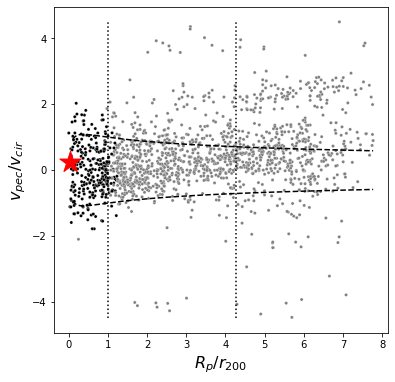

In [527]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
R_v_diagram(17, ax)       
plt.show()

In [514]:
cls_info.loc[17, ['ra', 'dec']]

ra     247.18045
dec     39.56877
Name: 17, dtype: float64

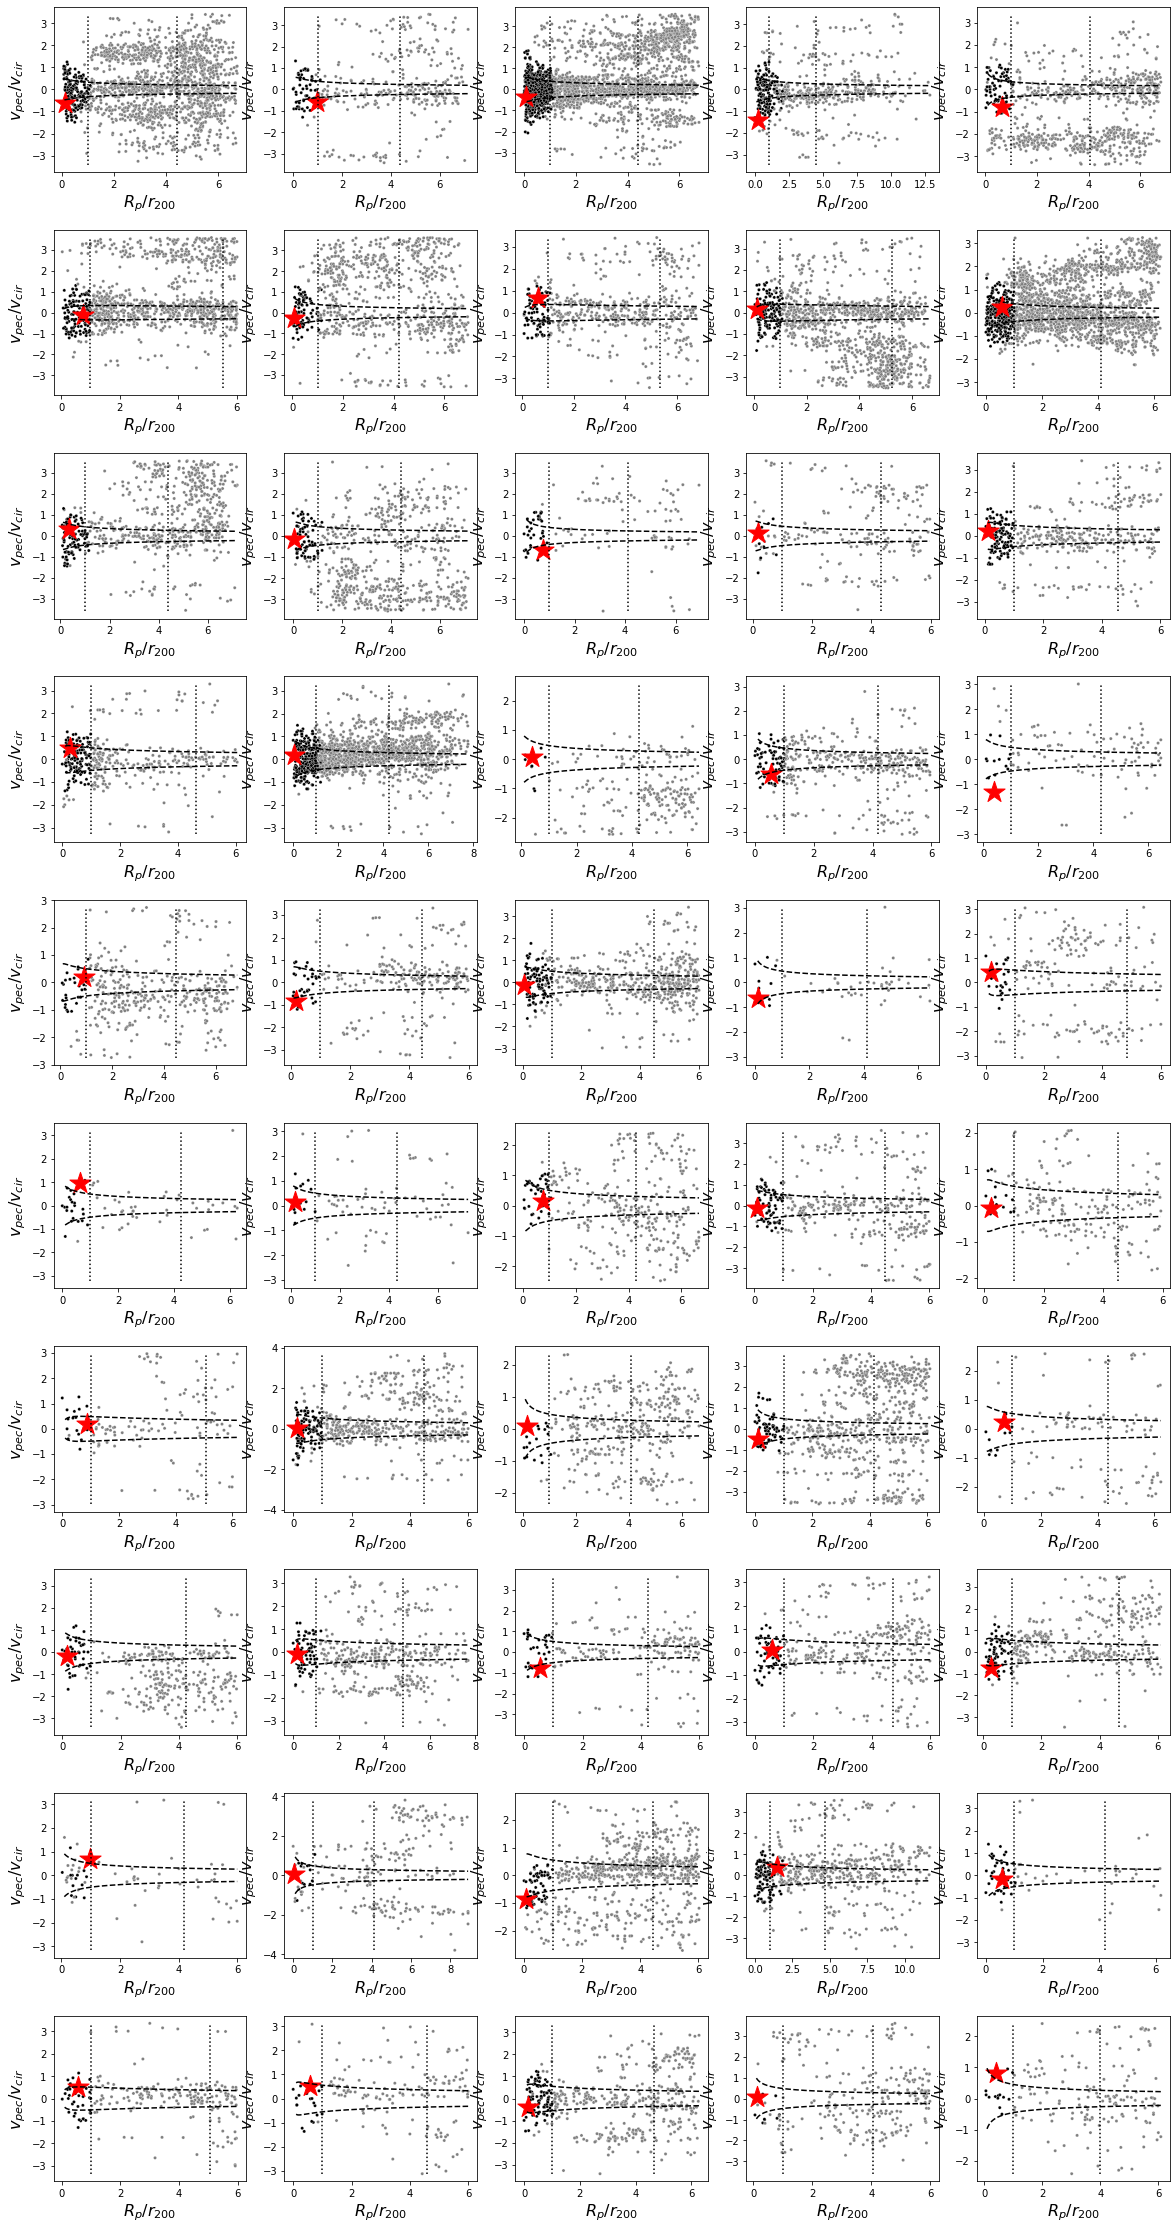

In [511]:
m, n = 10, 5
fig, ax = plt.subplots(m, n, figsize=(4*n, 4*m))
fig.subplots_adjust(hspace=0.35)

for row in range(m):
    for col in range(n):
        clid = n * row + col + 1
        R_v_diagram(clid, ax[row][col])
        
plt.show()

In [53]:
cls_info.columns

Index(['N_gal', 'ra', 'dec', 'z', 'comv_dist', 'v_rad', 'r_500', 'N_500',
       'sigma_500', 'M_500', 'r_200', 'N_200', 'sigma_200', 'M_200', 'r_100',
       'N_100', 'sigma_100', 'M_100', 'r_005', 'N_005', 'sigma_005', 'M_005',
       'R_s', 'M_s', 'concentration', 'r_005/r_200', 'v_c'],
      dtype='object')

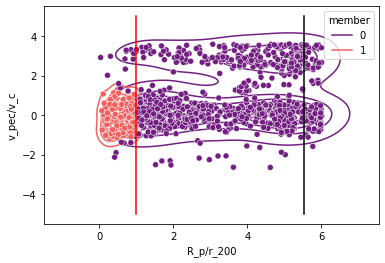

In [54]:
gal_df = gal_df_ls[5]
colors = gal_df.member.map({0:'black', 1:'red'}).values

sns.scatterplot(data=gal_df, x='R_p/r_200',
                y='v_pec/v_c', hue='member',
                palette='magma')
sns.kdeplot(data=gal_df, x='R_p/r_200',
            y='v_pec/v_c', hue='member',
            palette='magma', zorder=0, levels=6)

N = 100
v_max = round(1.33 * gal_df['v_pec/v_c'].apply(abs).max())

x1 = np.ones(N)
x2 = np.ones(N) * cls_info.iloc[5, -2]
y = np.linspace(-v_max, v_max, N)
plt.plot(x1, y, color='red')
plt.plot(x2, y, color='black')
plt.show()

In [ ]:
m, n = 10, 5
fig, ax = plt.subplots(m, n, figsize=(4*n, 4*m))

for row in range(m):
    for col in range(n):
        num = n * row + col
        gal_df = gal_df_ls[num]
        colors = gal_df.member.map({0:'black', 1:'red'}).values
        
        sns.scatterplot(data=gal_df, x='R_p/r_200',
                        y='v_pec/v_c', hue='member',
                        palette='magma', ax=ax[row][col])
        
        sns.kdeplot(data=gal_df, x='R_p/r_200',
                    y='v_pec/v_c', hue='member',
                    palette='magma', zorder=0,
                    levels=6, ax=ax[row][col])
        
        N = 100
        v_max = round(gal_df['v_pec/v_c'].apply(abs).max())
        
        x1 = np.ones(N)
        x2 = np.ones(N) * 3
        y = np.linspace(-v_max, v_max, N)
        
        ax[row][col].plot(x1, y, color='red')
        ax[row][col].plot(x2, y, color='black')
        ax[row][col].set_title(f"Cluster No.{num + 1}")
        
plt.show()

## Polar coordinate diagram

In [ ]:
import math

def cls_z_l_plot(data, ax):
    np.random.seed(19680801)

    N = len(data)
    z = data.redshift.values
    theta = data.l.values * deg2rad
    area = [10] * N
    colors = data.member.map({0:'black', 1:'r'}).values

    c = ax.scatter(theta, z, s=area, c=colors, alpha=1)
    
    ax.set_thetamin(data.ra.mean())
    ax.set_thetamax(math.ceil(data.l.max()))

In [56]:
def cls_plot(datalist):
    N = 0
    z = np.array([])
    theta = np.array([])
    areas = np.array([])
    colors = np.array([])
    
    for data in datalist:
        N += len(data)
        z = np.concatenate((z, data.z.values), axis=0)
        theta = np.concatenate((theta, data.ra.values), axis=0)
        colors = np.concatenate((colors, data.member.map({0:'black', 1:'r'}).values),
                                axis=0)
    print(f'N: {N}')
    area = [5] * N
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='polar')
#     ax.set_rorigin(-2.5)
    ax.scatter(theta * deg2rad, z, s=area, c=colors, alpha=1)
    
#     ax.set_thetamin(105)
#     ax.set_thetamax(270)

    plt.show()

N: 240136


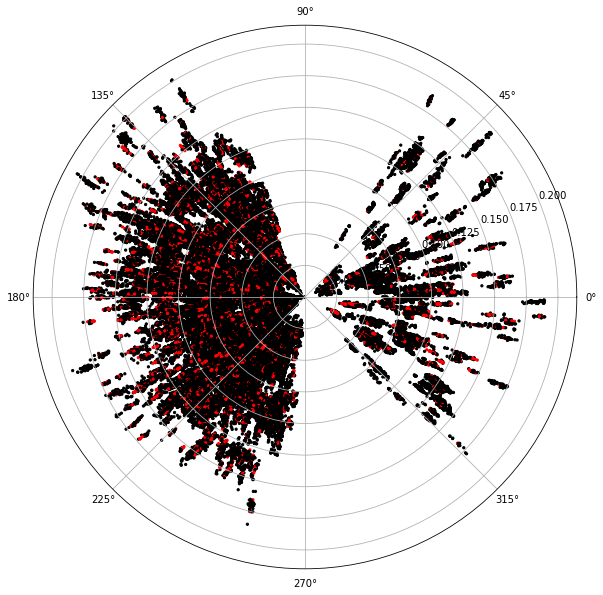

In [57]:
cls_plot(gal_df_ls)

N: 34459


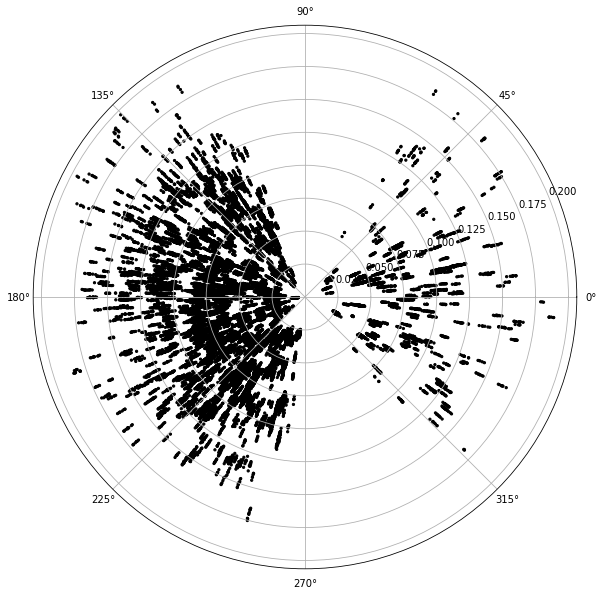

In [72]:
def galwcat19_plot(data):
    members = data[data.member == 1]
    N = len(members)
    print(f'N: {N}')
    area = [5] * N
    colors = np.array(['black'] * N)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='polar')
#     ax.set_rorigin(-2.5)
    ax.scatter(members.ra.values * deg2rad, members.z, s=area, c=colors, alpha=1)
    
#     ax.set_thetamin(105)
#     ax.set_thetamax(270)

    plt.show()
    
galwcat19_plot(gal_df_tot)

In [ ]:
print(min(gal_df_ls[1]['mag_g']))
bcg1 = gal_df_ls[1][gal_df_ls[1]['mag_g']==gal_df_ls[1]['mag_g'].min()]
bcg1_rmag = bcg1['mag_r'].values[0]
print(bcg1_rmag)
print(gal_df_ls[1]['mag_r'].min())

### Find BCG

In [ ]:
bcg_info = pd.DataFrame()

for idx, gal_df in enumerate(gal_df_ls):
    bcg = gal_df[gal_df['mag_r']==gal_df['mag_r'].min()]
    if len(bcg) > 1:
        bcg = bcg[bcg['mag_g']==bcg['mag_g'].min()]
    bcg['N_mem'] = len(gal_df)
    bcg_info = pd.concat([bcg_info, bcg], axis=0)

bcg_info

In [ ]:
obs_info = pd.DataFrame()

for idx, gal_df in enumerate(gal_df_ls):
    bcg = gal_df[gal_df['mag_r']==gal_df['mag_r'].min()]
    if len(bcg) > 1:
        bcg = bcg[bcg['mag_g']==bcg['mag_g'].min()]
    bcg['N_mem'] = len(gal_df)
    bcg_info = pd.concat([bcg_info, bcg], axis=0)

bcg_info

N_mem   sigma_200      z_cl         M_200   logM_200  logvelDisp  \
clid                                                                     
1     166.0  1042.08600  0.073177  1.354718e+15  14.991800    2.389144   
2      61.0   926.75761  0.113908  8.947211e+14  14.820353    2.389624   
3     670.0   932.60305  0.023372  8.757296e+14  14.792094    2.567817   
4     149.0   881.24884  0.080997  7.702466e+14  14.748231    2.399016   
5      75.0   842.65332  0.075065  7.588557e+14  14.740508    2.425245   
...     ...         ...       ...           ...        ...         ...   
1796   11.0   330.15092  0.018229  3.802129e+13  13.428723    2.222638   
1797    9.0   325.52783  0.083403  3.798733e+13  13.441749    2.310677   
1798   12.0   298.36618  0.076106  3.796280e+13  13.439926    2.381702   
1799   30.0   327.58401  0.040514  3.786609e+13  13.431439    2.304714   
1800   13.0   257.67623  0.055020  3.784301e+13  13.434152    2.265243   

      logsigma_200  
clid                
1         3.017904  
2         2.966966  
3         2.969697  
4         2.945099  
5         2.925649  
...            ...  
1796      2.518713  
1797      2.512588  
1798      2.474750  
1799      2.515323  
1800      2.411074  

[1800 rows x 7 columns]

In [ ]:
bcg_info.iloc[:, -7:]

In [ ]:
bcg_info = bcg_info.reset_index(drop=True)
bcg_info.index = bcg_info.index + 1
bcg_info = bcg_info.drop(columns=['frac_ellip','frac_spiral'])
bcg_info

In [ ]:
bcg_info = bcg_info.drop(columns=['pca_logmass'])

In [ ]:
cls_bcg_info = pd.merge(cls_info, bcg_info, left_index=True, right_index=True)
cls_bcg_info

In [ ]:
cls_bcg_info = cls_bcg_info.dropna()

In [528]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Compute areas and colors
N = len(cls_bcg_info)
area = [20] * N
colors = cls_bcg_info['z_y']

fig, ax = plt.subplots()

graph = ax.scatter(cls_bcg_info['velDisp'].apply(np.log10),
                   cls_bcg_info['sig200'].apply(np.log10),
                   c=colors, s=area, cmap='viridis', alpha=0.75)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(graph, cax=cax)

plt.show()

NameError: name 'cls_bcg_info' is not defined

In [ ]:
N = len(cls_bcg_info)
area = [20] * N
colors = cls_bcg_info['Ng'].apply(np.log10)

fig, ax = plt.subplots()

graph = ax.scatter(cls_bcg_info['pca_logmass'],
                   cls_bcg_info['M200'].apply(np.log10),
                   c=colors, s=area, cmap='viridis', alpha=0.75)

ax.set_xlabel('M_bcg')
ax.set_ylabel('M_cls')
ax.set_xlim(11, 12.2)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(graph, cax=cax)

plt.show()

## Linear Regression to predict M_200 of galaxy clusters

In [ ]:
import statsmodels.api as sm

x = bcg_info[['z', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z',
              'velDisp', 'passive_logmass', 'absMagK', 'N_mem']]
x.redshift = peculiar_v(x.redshift, cls_info['cluster redshift'], absolute=True)
x.columns = ['velPec', 'velDisp', 'passive_logmass', 'absMagK', 'N_mem']
x = x.drop(columns=['velDisp'])
x

In [ ]:
x = sm.add_constant(x)
y = cls_info['M_200']

model = sm.OLS(y, x).fit()
model.summary()

In [ ]:
def circular_v(mass, radius):
    # Units
    # 1) mass : solar mass
    # 2) radius : Mpc
    return np.sqrt(G * mass / radius)

def peculiar_v(z_obs, z_cls, absolute=False):
    # Calculating relativisitic peculiar velocity of radial direction
    z_pec = (1 + z_obs) / (1 + z_cls) - 1
    if absolute:
        z_pec = abs(z_pec)
    return radial_v(z_pec)

In [ ]:
v_c = circular_v(cls_info['M_200'], cls_info['r_200'])
cls_info['v_c'] = v_c
cls_info

In [ ]:
2 * v_c / cls_info['sigma_200']

In [ ]:
idx = 0
v_p = peculiar_v(gal_df_ls[idx]['redshift'], cls_info.loc[idx+1, 'z'])
v_ratio = v_p / v_c[idx+1]
print(v_ratio.max(), v_ratio.min())

## Regression with scikit-learn ML models

In [ ]:
# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm.sklearn import LGBMRegressor
from xgboost.sklearn import XGBRegressor

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
for X in X_list:
    errors = []
    models2 = [LinearRegression(),
               RandomForestRegressor(random_state=42),
               DecisionTreeRegressor(random_state=42),
               LGBMRegressor(random_state=42),
               XGBRegressor(random_state=42)]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

    print(f'---------- column : {X.columns} ----------')
    print()

    for model in models2:
        name = str(model).split('(')[0]
        model.fit(X3_train, y_train)
        predict = model.predict(X3_val)
        rmse = mean_squared_error(y_val, predict, squared=False)
        errors.append(rmse)
        print(f'---------- Model : {name} ----------')
        print('RMSE is ', rmse)
        print()
    
    min_error_index = errors.index(min(errors))
    final_models.append(models2[min_error_index])

## Final Preprocessing Class

In [261]:
def radial_v(z):
    # calculating relativistic radial velocity with redshift
    return c * ((z+1)**2 - 1)/((z+1)**2 + 1)

def dimless_h(z, h_0=0.7):
    # Calculating dimesionless hubble constant, h(z)
    # According to the GalWCat19 paper,
    # Omega(r, m, k, gamma) = (0, 0.3, 0, 0.7)
    # default: h_0 = 0.7
    return h_0 * np.sqrt(0.3*(1 + z)**3 + 0.7)

def absMag(mag, z, h_0):
    v_r = radial_v(z)
    h = dimless_h(z, h_0)
    return mag - 15 - 5 * np.log10(v_r/h)

In [262]:
def absMagK(mag_r):
    # M_K = 1.104 * M_r + 1.023
    return 1.104 * mag_r + 1.023
    
def velocity_dispersion(Mag_K):
    logsigma = -0.125 * Mag_K - 0.54
    return 10 ** logsigma

def stellar_logmass(Mag_K):
    return 1.92 - 0.4 * Mag_K

In [247]:
gal_df_tot = pd.concat(gal_df_ls, axis=0).reset_index()
gal_df_tot['galid'] = gal_df_tot['index']
gal_df_tot = gal_df_tot.drop(columns=['index', 'objid', 'l', 'b'])
gal_df_tot.head()

ra        dec     mag_u     mag_g     mag_r     mag_i     mag_z  \
0  229.000252  27.928189  18.65716  17.67503  17.29835  17.04418  17.01079   
1  229.065073  27.977843  18.73825  17.72186  17.11116  16.80350  16.42904   
2  228.439820  27.889472  18.70973  17.65587  17.10105  16.78820  16.65875   
3  228.410952  25.942005  18.88939  17.48792  16.70035  16.35189  16.09914   
4  228.543775  25.853865  18.55857  17.95040  17.84467  17.61918  17.68971   

          z      zErr    velDisp  ...  frac_ellip  frac_spiral  clid  member  \
0  0.076895  0.000008    0.00000  ...       0.033        0.878     1       0   
1  0.085256  0.000012  102.36550  ...       0.165        0.790     1       0   
2  0.090767  0.000011   78.06466  ...       0.192        0.751     1       0   
3  0.085341  0.000025  107.36240  ...       0.188        0.812     1       0   
4  0.054202  0.000006   75.35497  ...         NaN          NaN     1       0   

         v_pec  v_pec/sigma_200  v_pec/v_c        R_p  R_p/r_200  galid  
0  1037.001293         0.995121   0.569755   6.285339   3.573561      0  
1  3355.407705         3.219895   1.843546   6.067239   3.449559      1  
2  4873.669636         4.676840   2.677718   8.373645   4.760878      2  
3  3378.735182         3.242281   1.856363  10.843356   6.165045      3  
4 -5347.415022        -5.131453  -2.938005  10.676133   6.069969      4  

[5 rows x 28 columns]

In [263]:
# Absolute Magnitude Calculation
maglist = ['mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z']
absmaglist = ['absmag_u', 'absmag_g', 'absmag_r', 'absmag_i', 'absmag_z']

for mag, absmag in zip(maglist, absmaglist):
    gal_df_tot[absmag] = gal_df_tot.apply(lambda x: absMag(x[mag], cls_info.loc[x.clid, 'z'], 0.7),
                                    axis=1)
    
gal_df_tot.head()

ra        dec     mag_u     mag_g     mag_r     mag_i     mag_z  \
0  229.000252  27.928189  18.65716  17.67503  17.29835  17.04418  17.01079   
1  229.065073  27.977843  18.73825  17.72186  17.11116  16.80350  16.42904   
2  228.439820  27.889472  18.70973  17.65587  17.10105  16.78820  16.65875   
3  228.410952  25.942005  18.88939  17.48792  16.70035  16.35189  16.09914   
4  228.543775  25.853865  18.55857  17.95040  17.84467  17.61918  17.68971   

          z      zErr    velDisp  ...  v_pec/sigma_200  v_pec/v_c        R_p  \
0  0.076895  0.000008    0.00000  ...         0.995121   0.569755   6.285339   
1  0.085256  0.000012  102.36550  ...         3.219895   1.843546   6.067239   
2  0.090767  0.000011   78.06466  ...         4.676840   2.677718   8.373645   
3  0.085341  0.000025  107.36240  ...         3.242281   1.856363  10.843356   
4  0.054202  0.000006   75.35497  ...        -5.131453  -2.938005  10.676133   

   R_p/r_200  galid   absmag_u   absmag_g   absmag_r   absmag_i   absmag_z  
0   3.573561      0 -18.668319 -19.650449 -20.027129 -20.281299 -20.314689  
1   3.449559      1 -18.587229 -19.603619 -20.214319 -20.521979 -20.896439  
2   4.760878      2 -18.615749 -19.669609 -20.224429 -20.537279 -20.666729  
3   6.165045      3 -18.436089 -19.837559 -20.625129 -20.973589 -21.226339  
4   6.069969      4 -18.766909 -19.375079 -19.480809 -19.706299 -19.635769  

[5 rows x 33 columns]

In [264]:
gal_df_tot[gal_df_tot.pca_vdisp == 850]

Empty DataFrame
Columns: [ra, dec, mag_u, mag_g, mag_r, mag_i, mag_z, z, zErr, velDisp, velDispErr, passive_logmass, pca_logmass, logmass_lowerErr, logmass_upperErr, absMagK, pca_vdisp, pca_vdisp_err, frac_ellip, frac_spiral, clid, member, v_pec, v_pec/sigma_200, v_pec/v_c, R_p, R_p/r_200, galid, absmag_u, absmag_g, absmag_r, absmag_i, absmag_z]
Index: []

[0 rows x 33 columns]

In [265]:
wrong_veldisp_index = gal_df_tot[(gal_df_tot.velDisp == 0) | (gal_df_tot.velDisp == 850)].index

In [266]:
for idx in wrong_veldisp_index:
    gal_df_tot.loc[idx, 'velDisp'] = gal_df_tot.loc[idx, 'pca_vdisp']

gal_df_tot[(gal_df_tot.velDisp == 0) | (gal_df_tot.velDisp == 850)]

ra        dec     mag_u     mag_g     mag_r     mag_i  \
2138    187.994365  27.833891  19.79210  19.56265  19.75872  20.45572   
2228    196.521699  28.787438  19.26144  17.98683  17.24483  16.95254   
2442    199.175103  31.366964  15.72718  33.32507  34.35877  33.91617   
2517    202.413110  25.797528  18.93931  17.22826  16.93455  16.72840   
3275    196.438958  28.871341  18.27046  16.94380  16.62802  16.45178   
...            ...        ...       ...       ...       ...       ...   
233717  176.590670  20.177477  19.12292  18.10086  17.45050  17.17928   
238493  139.288408  27.481152  18.64790  17.74568  17.41234  17.20819   
238563  135.326674  29.507619  18.51529  17.69583  17.34265  17.26818   
238836  255.200268  35.150426  20.11297  25.04937  24.75703  24.32834   
238892  256.715587  34.662395  19.03331  18.69163  24.74595  17.72853   

           mag_z         z      zErr  velDisp  ...  v_pec/sigma_200  \
2138    21.62601  0.025208  0.000008      0.0  ...         0.576051   
2228    16.80977  0.023066  0.000062      0.0  ...        -0.096283   
2442    30.85916  0.019178  0.000007      0.0  ...        -1.320224   
2517    17.09794  0.024738  0.000012      0.0  ...         0.428801   
3275    16.50854  0.026551  0.000006      0.0  ...         0.996857   
...          ...       ...       ...      ...  ...              ...   
233717  17.18054  0.020256  0.000013      0.0  ...        -2.479275   
238493  16.97659  0.023555  0.000008      0.0  ...         1.029159   
238563  17.22833  0.021671  0.000016      0.0  ...        -0.638348   
238836  22.80198  0.029400  0.000019      0.0  ...        -1.370379   
238892  22.79584  0.030971  0.000006      0.0  ...         0.152512   

        v_pec/v_c       R_p  R_p/r_200  galid   absmag_u   absmag_g  \
2138     0.344061  8.422920   5.452258     47 -15.161368 -15.390818   
2228    -0.057508  2.203720   1.426494    137 -15.692028 -16.966638   
2442    -0.788537  6.640515   4.298485    351 -19.226288  -1.628398   
2517     0.256112  9.422662   6.099403    426 -16.014158 -17.725208   
3275     0.595398  2.169271   1.404195   1184 -16.683008 -18.009668   
...           ...       ...        ...    ...        ...        ...   
233717  -1.353846  2.125882   3.762914    573 -15.786253 -16.808313   
238493   0.611607  3.159202   5.727223     70 -16.214585 -17.116805   
238563  -0.379356  3.624574   6.570882    140 -16.347195 -17.166655   
238836  -0.739638  2.864072   5.221953     46 -15.425036 -10.488636   
238892   0.082316  0.574898   1.048189    102 -16.504696 -16.846376   

         absmag_r   absmag_i   absmag_z  
2138   -15.194748 -14.497748 -13.327458  
2228   -17.708638 -18.000928 -18.143698  
2442    -0.594698  -1.037298  -4.094308  
2517   -18.018918 -18.225068 -17.855528  
3275   -18.325448 -18.501688 -18.444928  
...           ...        ...        ...  
233717 -17.458673 -17.729893 -17.728633  
238493 -17.450145 -17.654295 -17.885895  
238563 -17.519835 -17.594305 -17.634155  
238836 -10.780976 -11.209666 -12.736026  
238892 -10.792056 -17.809476 -12.742166  

[146 rows x 33 columns]

In [267]:
wrong_veldisp_index2 = gal_df_tot[gal_df_tot.velDisp == 0].index

In [268]:
gal_df_tot[gal_df_tot.passive_logmass < 0]

Empty DataFrame
Columns: [ra, dec, mag_u, mag_g, mag_r, mag_i, mag_z, z, zErr, velDisp, velDispErr, passive_logmass, pca_logmass, logmass_lowerErr, logmass_upperErr, absMagK, pca_vdisp, pca_vdisp_err, frac_ellip, frac_spiral, clid, member, v_pec, v_pec/sigma_200, v_pec/v_c, R_p, R_p/r_200, galid, absmag_u, absmag_g, absmag_r, absmag_i, absmag_z]
Index: []

[0 rows x 33 columns]

In [269]:
nullIndex = gal_df_tot[gal_df_tot.drop(columns=['frac_ellip', 'frac_spiral']).isnull().any(axis=1)].index
nullIndex

Int64Index([    52,    213,    228,    255,    312,    441,    523,    666,
              1082,   1100,
            ...
            239861, 239877, 239953, 239994, 240002, 240025, 240043, 240086,
            240110, 240129],
           dtype='int64', length=9092)

In [270]:
for idx in wrong_veldisp_index:
    gal_df_tot.loc[idx, 'velDisp'] = velocity_dispersion(gal_df_tot.loc[idx, 'absMagK'])

In [271]:
for idx in nullIndex:
    Mag_K = absMagK(gal_df_tot.loc[idx, 'absmag_r'])
    gal_df_tot.loc[idx, 'absMagK'] = Mag_K
    gal_df_tot.loc[idx, 'velDisp'] = velocity_dispersion(Mag_K)
    gal_df_tot.loc[idx, 'passive_logmass'] = stellar_logmass(Mag_K)

In [272]:
gal_df_tot.isnull().sum()

ra                      0
dec                     0
mag_u                   0
mag_g                   0
mag_r                   0
mag_i                   0
mag_z                   0
z                       0
zErr                    0
velDisp                 0
velDispErr              0
passive_logmass         0
pca_logmass          9092
logmass_lowerErr     9092
logmass_upperErr     9092
absMagK                 0
pca_vdisp            9092
pca_vdisp_err        9092
frac_ellip          35423
frac_spiral         35423
clid                    0
member                  0
v_pec                   0
v_pec/sigma_200         0
v_pec/v_c               0
R_p                     0
R_p/r_200               0
galid                   0
absmag_u                0
absmag_g                0
absmag_r                0
absmag_i                0
absmag_z                0
dtype: int64

## Find BCG

In [477]:
bcg_info = pd.DataFrame()

for clid in cls_info.index:
    cls_df = gal_df_tot[(gal_df_tot.clid == clid) & (gal_df_tot.member == 1)]
    bcg = cls_df[cls_df.absMagK == cls_df.absMagK.min()]
    if len(bcg) > 1:
        bcg = cls_df[cls_df.mag_r == cls_df.mag_r.min()]
    bcg[['N_mem', 'sigma_200', 'z_cl', 'M_200']] = cls_info.loc[clid, ['N_gal', 'sigma_200', 'z', 'M_200']]
    bcg['logM_200'] = np.log10(cls_info.loc[clid, 'M_200'] * dimless_h(cls_info.loc[clid, 'z']))
    bcg['logvelDisp'] = np.log10(bcg.velDisp)
    bcg['logsigma_200'] = np.log10(bcg.sigma_200)
    bcg_info = pd.concat([bcg_info, bcg], axis=0)

bcg_info

ra        dec     mag_u     mag_g     mag_r     mag_i  \
1435    230.600086  27.714371  18.00471  15.85412  14.93852  14.51154   
1905    227.503266  33.251470  18.83600  16.74954  15.75994  15.32730   
3011    195.033862  27.976941  14.61542  12.60647  11.68674  11.48705   
4835    258.119946  64.060748  28.96740  14.89604  14.05970  13.49466   
6093    209.642979  28.119242  17.82182  15.86193  14.96279  14.52897   
...            ...        ...       ...       ...       ...       ...   
239857  219.705111  41.007144  16.25774  14.33368  13.51766  13.08858   
239906  244.120996  17.315482  18.24612  16.69145  15.79146  15.39666   
239952  195.662678  62.494249  17.76538  15.40607  14.51318  14.12203   
240025  122.148485  38.914502  16.99637  15.45189  14.57127  14.17952   
240089  214.098367   3.682378  18.54773  16.56806  15.71361  15.31814   

           mag_z         z      zErr     velDisp  ...   absmag_r   absmag_i  \
1435    14.36175  0.069041  0.000017  244.987700  ... -22.386959 -22.813939   
1905    14.95065  0.110372  0.000016  245.258600  ... -22.437031 -22.869671   
3011    11.22920  0.021502  0.000011  369.672000  ... -23.266728 -23.466418   
4835    13.74724  0.073438  0.000016  250.619900  ... -23.469249 -24.034289   
6093    14.26415  0.070886  0.000012  266.222532  ... -22.413912 -22.847732   
...          ...       ...       ...         ...  ...        ...        ...   
239857  12.82439  0.018971  0.000010  166.969900  ... -20.906866 -21.335946   
239906  15.11215  0.081628  0.000019  204.492400  ... -21.795793 -22.190593   
239952  14.10226  0.075739  0.000013  240.825400  ... -22.891158 -23.282308   
240025  14.10219  0.040815  0.000008  201.703673  ... -21.540499 -21.932249   
240089  14.99818  0.053943  0.000013  184.180300  ... -21.031762 -21.427232   

         absmag_z  N_mem   sigma_200      z_cl         M_200   logM_200  \
1435   -22.963729  166.0  1042.08600  0.073177  1.354718e+15  14.991800   
1905   -23.246321   61.0   926.75761  0.113908  8.947211e+14  14.820353   
3011   -23.724268  670.0   932.60305  0.023372  8.757296e+14  14.792094   
4835   -23.781709  149.0   881.24884  0.080997  7.702466e+14  14.748231   
6093   -23.112552   75.0   842.65332  0.075065  7.588557e+14  14.740508   
...           ...    ...         ...       ...           ...        ...   
239857 -21.600136   11.0   330.15092  0.018229  3.802129e+13  13.428723   
239906 -22.475103    9.0   325.52783  0.083403  3.798733e+13  13.441749   
239952 -23.302078   12.0   298.36618  0.076106  3.796280e+13  13.439926   
240025 -22.009579   30.0   327.58401  0.040514  3.786609e+13  13.431439   
240089 -21.747192   13.0   257.67623  0.055020  3.784301e+13  13.434152   

        logvelDisp  logsigma_200  
1435      2.389144      3.017904  
1905      2.389624      2.966966  
3011      2.567817      2.969697  
4835      2.399016      2.945099  
6093      2.425245      2.925649  
...            ...           ...  
239857    2.222638      2.518713  
239906    2.310677      2.512588  
239952    2.381702      2.474750  
240025    2.304714      2.515323  
240089    2.265243      2.411074  

[1800 rows x 40 columns]

In [478]:
bcg_index = bcg_info.index

In [483]:
gal_df_tot['bcg'] = 0
gal_df_tot.loc[bcg_index, 'bcg'] = 1
gal_df_tot.bcg.value_counts()

0    238336
1      1800
Name: bcg, dtype: int64

In [479]:
bcg_info = bcg_info.dropna(axis=1)
bcg_info

ra        dec     mag_u     mag_g     mag_r     mag_i  \
1435    230.600086  27.714371  18.00471  15.85412  14.93852  14.51154   
1905    227.503266  33.251470  18.83600  16.74954  15.75994  15.32730   
3011    195.033862  27.976941  14.61542  12.60647  11.68674  11.48705   
4835    258.119946  64.060748  28.96740  14.89604  14.05970  13.49466   
6093    209.642979  28.119242  17.82182  15.86193  14.96279  14.52897   
...            ...        ...       ...       ...       ...       ...   
239857  219.705111  41.007144  16.25774  14.33368  13.51766  13.08858   
239906  244.120996  17.315482  18.24612  16.69145  15.79146  15.39666   
239952  195.662678  62.494249  17.76538  15.40607  14.51318  14.12203   
240025  122.148485  38.914502  16.99637  15.45189  14.57127  14.17952   
240089  214.098367   3.682378  18.54773  16.56806  15.71361  15.31814   

           mag_z         z      zErr     velDisp  ...   absmag_r   absmag_i  \
1435    14.36175  0.069041  0.000017  244.987700  ... -22.386959 -22.813939   
1905    14.95065  0.110372  0.000016  245.258600  ... -22.437031 -22.869671   
3011    11.22920  0.021502  0.000011  369.672000  ... -23.266728 -23.466418   
4835    13.74724  0.073438  0.000016  250.619900  ... -23.469249 -24.034289   
6093    14.26415  0.070886  0.000012  266.222532  ... -22.413912 -22.847732   
...          ...       ...       ...         ...  ...        ...        ...   
239857  12.82439  0.018971  0.000010  166.969900  ... -20.906866 -21.335946   
239906  15.11215  0.081628  0.000019  204.492400  ... -21.795793 -22.190593   
239952  14.10226  0.075739  0.000013  240.825400  ... -22.891158 -23.282308   
240025  14.10219  0.040815  0.000008  201.703673  ... -21.540499 -21.932249   
240089  14.99818  0.053943  0.000013  184.180300  ... -21.031762 -21.427232   

         absmag_z  N_mem   sigma_200      z_cl         M_200   logM_200  \
1435   -22.963729  166.0  1042.08600  0.073177  1.354718e+15  14.991800   
1905   -23.246321   61.0   926.75761  0.113908  8.947211e+14  14.820353   
3011   -23.724268  670.0   932.60305  0.023372  8.757296e+14  14.792094   
4835   -23.781709  149.0   881.24884  0.080997  7.702466e+14  14.748231   
6093   -23.112552   75.0   842.65332  0.075065  7.588557e+14  14.740508   
...           ...    ...         ...       ...           ...        ...   
239857 -21.600136   11.0   330.15092  0.018229  3.802129e+13  13.428723   
239906 -22.475103    9.0   325.52783  0.083403  3.798733e+13  13.441749   
239952 -23.302078   12.0   298.36618  0.076106  3.796280e+13  13.439926   
240025 -22.009579   30.0   327.58401  0.040514  3.786609e+13  13.431439   
240089 -21.747192   13.0   257.67623  0.055020  3.784301e+13  13.434152   

        logvelDisp  logsigma_200  
1435      2.389144      3.017904  
1905      2.389624      2.966966  
3011      2.567817      2.969697  
4835      2.399016      2.945099  
6093      2.425245      2.925649  
...            ...           ...  
239857    2.222638      2.518713  
239906    2.310677      2.512588  
239952    2.381702      2.474750  
240025    2.304714      2.515323  
240089    2.265243      2.411074  

[1800 rows x 33 columns]

In [480]:
bcg_info = bcg_info.set_index(keys=['clid'])

In [481]:
bcg_info

ra        dec     mag_u     mag_g     mag_r     mag_i     mag_z  \
clid                                                                            
1     230.600086  27.714371  18.00471  15.85412  14.93852  14.51154  14.36175   
2     227.503266  33.251470  18.83600  16.74954  15.75994  15.32730  14.95065   
3     195.033862  27.976941  14.61542  12.60647  11.68674  11.48705  11.22920   
4     258.119946  64.060748  28.96740  14.89604  14.05970  13.49466  13.74724   
5     209.642979  28.119242  17.82182  15.86193  14.96279  14.52897  14.26415   
...          ...        ...       ...       ...       ...       ...       ...   
1796  219.705111  41.007144  16.25774  14.33368  13.51766  13.08858  12.82439   
1797  244.120996  17.315482  18.24612  16.69145  15.79146  15.39666  15.11215   
1798  195.662678  62.494249  17.76538  15.40607  14.51318  14.12203  14.10226   
1799  122.148485  38.914502  16.99637  15.45189  14.57127  14.17952  14.10219   
1800  214.098367   3.682378  18.54773  16.56806  15.71361  15.31814  14.99818   

             z      zErr     velDisp  ...   absmag_r   absmag_i   absmag_z  \
clid                                  ...                                    
1     0.069041  0.000017  244.987700  ... -22.386959 -22.813939 -22.963729   
2     0.110372  0.000016  245.258600  ... -22.437031 -22.869671 -23.246321   
3     0.021502  0.000011  369.672000  ... -23.266728 -23.466418 -23.724268   
4     0.073438  0.000016  250.619900  ... -23.469249 -24.034289 -23.781709   
5     0.070886  0.000012  266.222532  ... -22.413912 -22.847732 -23.112552   
...        ...       ...         ...  ...        ...        ...        ...   
1796  0.018971  0.000010  166.969900  ... -20.906866 -21.335946 -21.600136   
1797  0.081628  0.000019  204.492400  ... -21.795793 -22.190593 -22.475103   
1798  0.075739  0.000013  240.825400  ... -22.891158 -23.282308 -23.302078   
1799  0.040815  0.000008  201.703673  ... -21.540499 -21.932249 -22.009579   
1800  0.053943  0.000013  184.180300  ... -21.031762 -21.427232 -21.747192   

      N_mem   sigma_200      z_cl         M_200   logM_200  logvelDisp  \
clid                                                                     
1     166.0  1042.08600  0.073177  1.354718e+15  14.991800    2.389144   
2      61.0   926.75761  0.113908  8.947211e+14  14.820353    2.389624   
3     670.0   932.60305  0.023372  8.757296e+14  14.792094    2.567817   
4     149.0   881.24884  0.080997  7.702466e+14  14.748231    2.399016   
5      75.0   842.65332  0.075065  7.588557e+14  14.740508    2.425245   
...     ...         ...       ...           ...        ...         ...   
1796   11.0   330.15092  0.018229  3.802129e+13  13.428723    2.222638   
1797    9.0   325.52783  0.083403  3.798733e+13  13.441749    2.310677   
1798   12.0   298.36618  0.076106  3.796280e+13  13.439926    2.381702   
1799   30.0   327.58401  0.040514  3.786609e+13  13.431439    2.304714   
1800   13.0   257.67623  0.055020  3.784301e+13  13.434152    2.265243   

      logsigma_200  
clid                
1         3.017904  
2         2.966966  
3         2.969697  
4         2.945099  
5         2.925649  
...            ...  
1796      2.518713  
1797      2.512588  
1798      2.474750  
1799      2.515323  
1800      2.411074  

[1800 rows x 32 columns]

In [318]:
bcg_info.columns

Index(['ra', 'dec', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'z', 'zErr',
       'velDisp', 'velDispErr', 'passive_logmass', 'absMagK', 'member',
       'v_pec', 'v_pec/sigma_200', 'v_pec/v_c', 'R_p', 'R_p/r_200', 'galid',
       'absmag_u', 'absmag_g', 'absmag_r', 'absmag_i', 'absmag_z', 'N_mem',
       'sigma_200', 'z_cl', 'logM_200', 'logvelDisp', 'logsigma_200'],
      dtype='object')

In [319]:
bcg_info[['logvelDisp', 'passive_logmass', 'absMagK', 'v_pec/sigma_200', 'R_p/r_200']]

logvelDisp  passive_logmass    absMagK  v_pec/sigma_200  R_p/r_200
clid                                                                    
1       2.389144        11.510000 -23.500000        -1.110841   0.142410
2       2.404183        11.560000 -23.720000         0.102773   0.021902
3       2.567817        11.760000 -24.040000        -0.588090   0.092928
4       2.399016        11.950000 -24.550000        -2.387130   0.254446
5       2.425245        11.408783 -23.721958        -1.385669   0.641139
...          ...              ...        ...              ...        ...
1796    2.222638        10.910000 -21.910000         0.662109   0.745651
1797    2.310677        11.110000 -23.020000        -1.509307   0.171159
1798    2.381702        11.790000 -24.160000        -0.342640   0.032133
1799    2.304714        11.023084 -22.757710         0.265118   0.213140
1800    2.265243        10.980000 -22.210000        -1.187878   0.333701

[1800 rows x 5 columns]

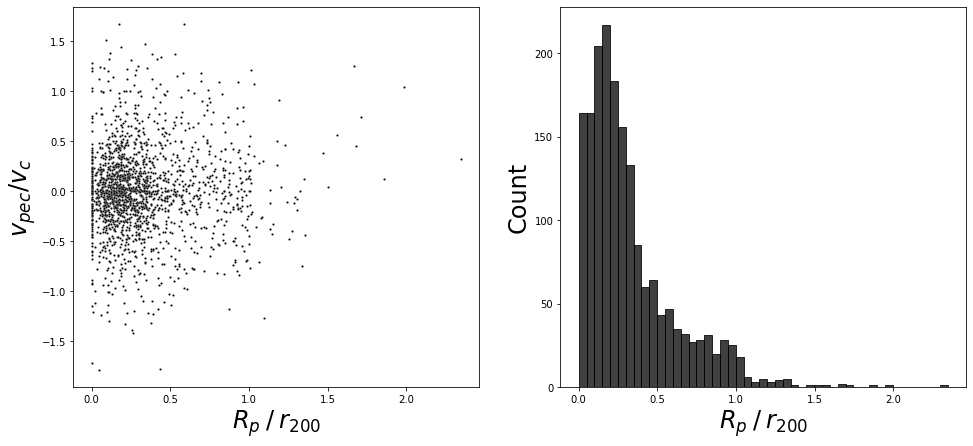

In [697]:
_, ax = plt.subplots(1,2, figsize=(16, 7))
sns.scatterplot(data=bcg_info, 
                x='R_p/r_200', 
                y='v_pec/v_c',
                color='black',
                s=5, ax=ax[0])

ax[0].set_xlabel('$R_{p}\: /\:r_{200}$', fontsize=24)
ax[0].set_ylabel('$v_{pec}/v_{c}$', fontsize=24)

sns.histplot(data=bcg_info, x='R_p/r_200',
             color='black', ax=ax[1])
ax[1].set_xlabel('$R_{p}\: /\:r_{200}$', fontsize=24)
ax[1].set_ylabel('Count', fontsize=24)
plt.show()

Text(0, 0.5, 'Count')

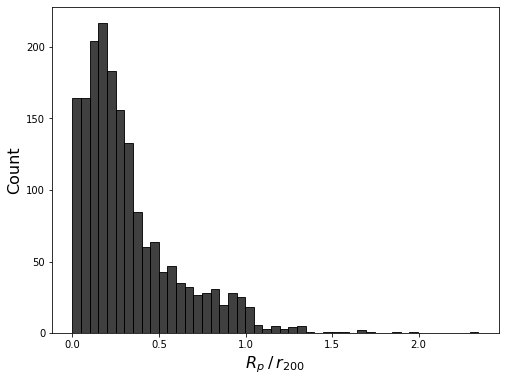

In [386]:
_, ax = plt.subplots(1,1, figsize=(8, 6))
ax = sns.histplot(data=bcg_info, x='R_p/r_200', color='black')
ax.set_xlabel('$R_{p}\: /\:r_{200}$', fontsize=16)
ax.set_ylabel('Count', fontsize=16)

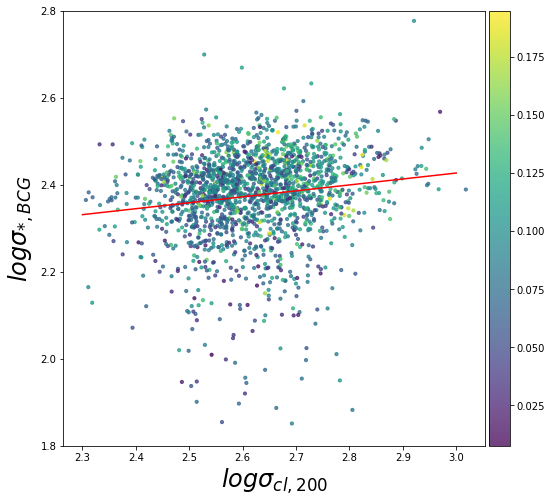

In [626]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Compute areas and colors
N = len(bcg_info)
area = [10] * N
colors = bcg_info['z_cl']

fig, ax = plt.subplots(1,1,figsize=(8,8))

graph = ax.scatter(bcg_info['logsigma_200'],
                   bcg_info['logvelDisp'],
                   c=colors, s=area, cmap='viridis', alpha=0.75)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(graph, cax=cax)


N = 200
x = np.linspace(2.3, 3, 200)
y = 0.1367 * x + 2.0169 * np.ones(N)
ax.plot(x, y, '-', color='red')

# ax.set_xlim(2.3, 3)
ax.set_ylim(1.8, 2.8)
ax.set_xlabel('$log\sigma_{cl,200}$', fontsize=24)
ax.set_ylabel('$log\sigma_{*,BCG}$', fontsize=24)

plt.show()

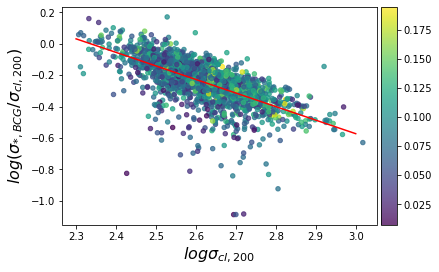

In [634]:
# Compute areas and colors
N = len(bcg_info)
area = [20] * N
colors = bcg_info['z_cl']

fig, ax = plt.subplots()

graph = ax.scatter(bcg_info['logsigma_200'],
                   bcg_info['logvelDisp'] - bcg_info['logsigma_200'],
                   c=colors, s=area, cmap='viridis', alpha=0.75)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(graph, cax=cax)


N = 200
x = np.linspace(2.3, 3, 200)
y = -0.863 * x + 2.0169 * np.ones(N)
ax.plot(x, y, '-', color='red')

# ax.set_xlim(1.6, 2.8)
ax.set_xlabel('$log\sigma_{cl,200}$', fontsize=16)
ax.set_ylabel('$log(\sigma_{*,BCG}/\sigma_{cl,200})$', fontsize=16)

plt.show()

In [632]:
X = bcg_info.logsigma_200
y = bcg_info.logvelDisp - bcg_info.logsigma_200
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     1361.
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          2.64e-222
Time:                        22:00:39   Log-Likelihood:                 1450.9
No. Observations:                1800   AIC:                            -2898.
Df Residuals:                    1798   BIC:                            -2887.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.0169      0.061     32.881      0.000       1.897       2.137
logsigma_200    -0.8633      0.023    -36.891      0.000      -0.909      -0.817
==============================================================================
Omnibus:                      815.327   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6262.333
Skew:                          -1.960   Prob(JB):                         0.00
Kurtosis:                      11.254   Cond. No.                         72.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [327]:
bcg_info['R_p/r_200'].mean(), bcg_info['R_p/r_200'].median()

(0.3247839888708533, 0.23766683509865097)

In [332]:
gal_df_tot['R_p/r_200'].mean()

3.5754192820168558

In [333]:
gal_df_tot['R_p/r_200'].median()

3.737928778170792

In [330]:
gal_df_tot.loc[gal_df_tot.member == 1, 'R_p/r_200'].mean()

0.514876147056985

In [331]:
gal_df_tot.loc[gal_df_tot.member == 1, 'R_p/r_200'].median()

0.46762505106534413

In [287]:
bcg_main_features = bcg_info[['absMagK', 'logvelDisp', 'passive_logmass']]
target_features = bcg_info[['logM_200', 'logsigma_200', 'z_cl', 'N_mem']]

## $M_{*,BCG} - N_{mem}$ relation

(0.0, 200.0)

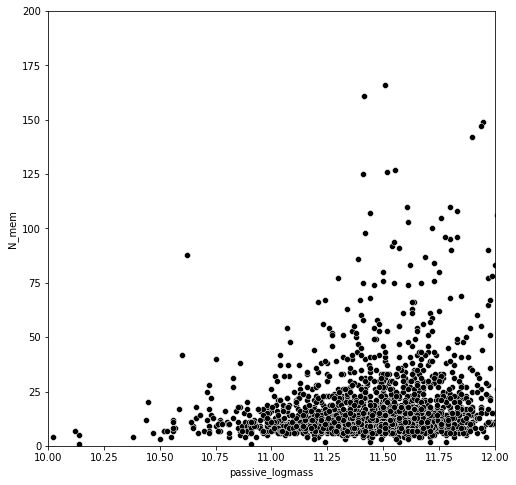

In [387]:
_, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(data=bcg_info, y='N_mem', x='passive_logmass', color='black')
ax.set_xlim(10, 12)
ax.set_ylim(0, 200)

## $M_{*,BCG} - M_{200}$ relation

In [401]:
bcg_info['stellar_mass'] = bcg_info.passive_logmass.apply(lambda x: 10 ** x)

As a further analysis, we investigate the M∗−Mhalo relationship
for the different subsamples: (i) low versus high redshift, and (ii)
groups versus clusters separated at Mhalo = 1014 M. The powerlaw indexes for the low-redshift sample (b = 0.33 ± 0.21), and
high-redshift sample (b = 0.30 ± 0.20) are consistent within the error bars, while the differences between groups and clusters is more
apparent. The relationship is shallower for the groups than for the
clusters, b = 0.19 ± 0.20, and b = 0.39 ± 0.16, respectively.

Oliva-Altamirano, P., et al. (2014)

- 0.32±0.09 (Oliva-Altamirano et al. 2014)
- 0.46±0.03 (Sohn et al. 2019)
- 0.41±0.04 (Erfanianfar et al. 2019)

<Sohn et al. 2019>
- log σ∗,BCG = (0.46 ± 0.09) log σcl + (1.16 ± 3.45)
- log σ∗,BCG = (0.13±0.01) log(M200,cl/M⊙)+(0.61±3.19)

- log(M∗,BCG/M200) = (−0.77±0.12)logM200+(8.39±4.05)
- σ∗,BCG/σcl = (−0.82 ± 0.17) log σcl + (2.77 ± 3.93).

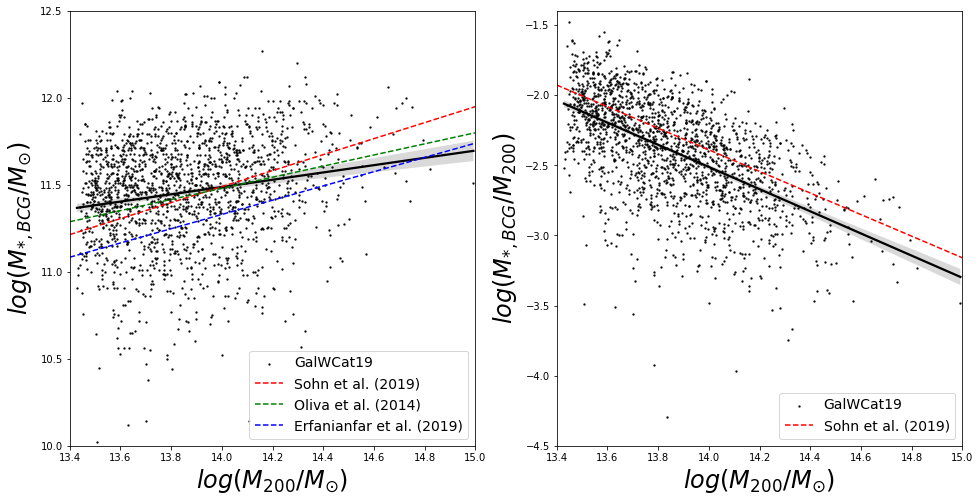

In [686]:
_, ax = plt.subplots(1,2, figsize=(16, 8))
sns.regplot(data=bcg_info,
            y='passive_logmass', 
            x='logM_200', 
            color='black',
            scatter_kws={'s':2}, 
            label='GalWCat19',
            ax=ax[0])

N = 200
x = np.linspace(13.4, 15, 200)
y_sohn = 0.46 * x + 5.05 * np.ones(N)
y_Oliva = 0.32 * x + 7.0 * np.ones(N)
y_Erfa = 0.41 * x + 5.59 * np.ones(N)
ax[0].plot(x, y_sohn, '--', color='red', label='Sohn et al. (2019)')
ax[0].plot(x, y_Oliva, '--', color='green', label='Oliva et al. (2014)')
ax[0].plot(x, y_Erfa, '--', color='blue', label='Erfanianfar et al. (2019)')

ax[0].set_ylabel('$log(M_{*,BCG}/M_{\odot})$', fontsize=24)
ax[0].set_xlabel('$log(M_{200}/M_{\odot})$', fontsize=24)
ax[0].legend(loc=4, fontsize=14)
ax[0].set_xlim(13.4, 15)
ax[0].set_ylim(10, 12.5)

sns.regplot(data=bcg_info, 
            x='logM_200', 
            y='logM_bcg/M_200', 
            color='black',
            scatter_kws={'s':2},
            ax=ax[1], 
            label='GalWCat19')
N = 200
x = np.linspace(13.4, 15, 200)
y_sohn = -0.77 * x + 8.39 * np.ones(N)
ax[1].plot(x, y_sohn, '--', color='red', label='Sohn et al. (2019)')

ax[1].set_ylabel('$log(M_{*,BCG}/M_{200})$', fontsize=24)
ax[1].set_xlabel('$log(M_{200}/M_{\odot})$', fontsize=24)
# ax.text(14.4, -2.1, '<Sohn et al. (2019)>\nSlope: -0.77 $\pm$0.12\nIntercept: 8.39 $\pm$ 4.05', fontsize=14)
# ax.text(14.4, -4, '\nSlope: -0.79 $\pm$ 0.03\nIntercept: 8.55 $\pm$ 0.37', fontsize=14)
ax[1].set_xlim(13.4, 15)
ax[1].set_ylim(-4.5, -1.4)
ax[1].legend(loc=4, fontsize=14)

# plt.show()
plt.savefig('./images/M_cl-M_bcg relation.png', dpi=300)

In [428]:
X = bcg_info.logM_200
y = bcg_info.passive_logmass
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        passive_logmass   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     60.25
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.39e-14
Time:                        07:02:04   Log-Likelihood:                -425.01
No. Observations:                1800   AIC:                             854.0
Df Residuals:                    1798   BIC:                             865.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5532      0.374     22.855      0.000       7.819       9.287
logM_200       0.2096      0.027      7.762      0.000       0.157       0.263
==============================================================================
Omnibus:                      353.781   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              935.650
Skew:                          -1.039   Prob(JB):                    6.70e-204
Kurtosis:                       5.856   Cond. No.                         721.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

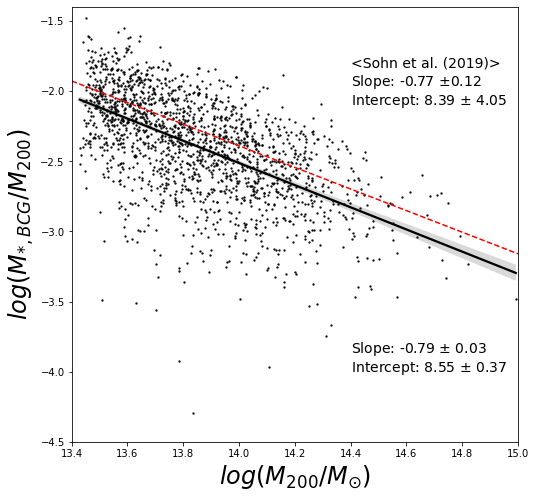

In [601]:
bcg_info['logM_bcg/M_200'] = bcg_info.passive_logmass - bcg_info.logM_200

_, ax = plt.subplots(1,1, figsize=(8, 8))
ax = sns.regplot(data=bcg_info, 
                 x='logM_200', 
                 y='logM_bcg/M_200', 
                 color='black',
                 scatter_kws={'s':2})
N = 200
x = np.linspace(13.4, 15, 200)
y_sohn = -0.77 * x + 8.39 * np.ones(N)
ax.plot(x, y_sohn, '--', color='red')

ax.set_ylabel('$log(M_{*,BCG}/M_{200})$', fontsize=24)
ax.set_xlabel('$log(M_{200}/M_{\odot})$', fontsize=24)
ax.text(14.4, -2.1, '<Sohn et al. (2019)>\nSlope: -0.77 $\pm$0.12\nIntercept: 8.39 $\pm$ 4.05', fontsize=14)
ax.text(14.4, -4, '\nSlope: -0.79 $\pm$ 0.03\nIntercept: 8.55 $\pm$ 0.37', fontsize=14)
ax.set_xlim(13.4, 15)
ax.set_ylim(-4.5, -1.4)
plt.show()

In [456]:
X = bcg_info.logM_200
y = bcg_info['logM_bcg/M_200']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         logM_bcg/M_200   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     856.7
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          2.43e-154
Time:                        13:24:47   Log-Likelihood:                -425.01
No. Observations:                1800   AIC:                             854.0
Df Residuals:                    1798   BIC:                             865.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5532      0.374     22.855      0.000       7.819       9.287
logM_200      -0.7904      0.027    -29.269      0.000      -0.843      -0.737
==============================================================================
Omnibus:                      353.781   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              935.650
Skew:                          -1.039   Prob(JB):                    6.70e-204
Kurtosis:                       5.856   Cond. No.                         721.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$logM_{*,BCG} = (0.2096 \pm 0.027) logM_{200} + (8.553 \pm 0.374)$

In [397]:
1/0.2096, 1/(0.2096-0.027), 1/(0.2096+0.027)

(4.770992366412213, 5.476451259583789, 4.22654268808115)

In [411]:
(8.553+0.374) / (0.2096-0.027), 8.553/0.2096, (8.553-0.374) / (0.2096+0.027)

(48.888280394304495, 40.80629770992367, 34.56889264581572)

In [300]:
(42.106-37.135) / 2

2.485500000000002

$log(M_{*,BCG}/M_{200}) = (-0.79 \pm 0.03) logM_{200} + (8.55 \pm 0.37)$

## $\sigma_{*,BCG}-\sigma_{200}$ relation

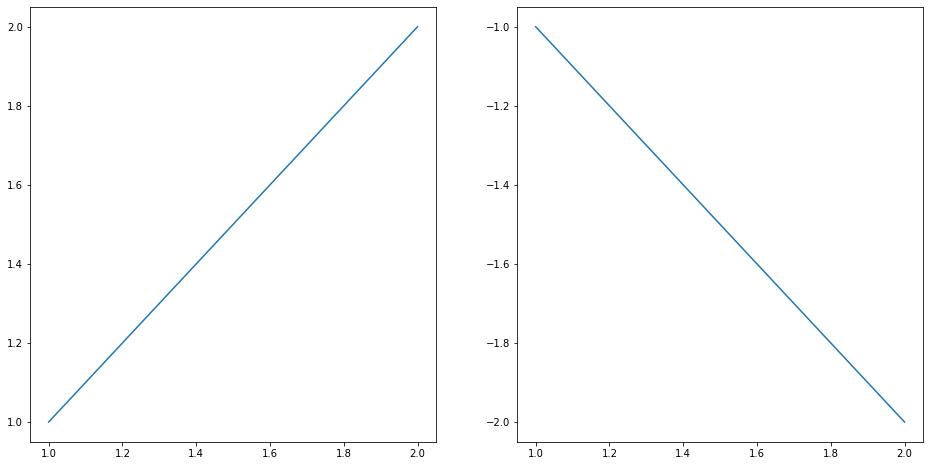

In [663]:
_, ax = plt.subplots(1,2, figsize=(16, 8))
ax[0].plot([1,2], [1,2])
ax[1].plot([1,2], [-1,-2])

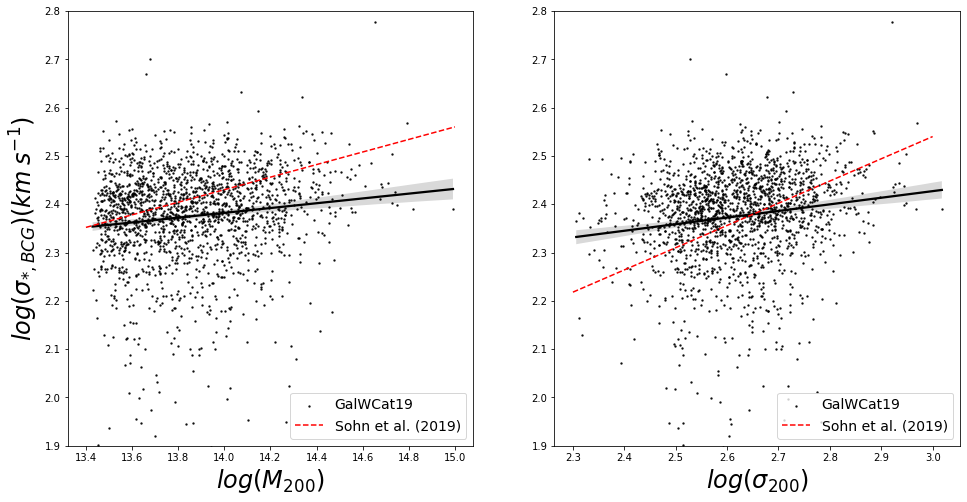

In [689]:
_, ax = plt.subplots(1,2, figsize=(16, 8))
sns.regplot(data=bcg_info,
            x='logM_200',
            y='logvelDisp', 
            color='black',
            scatter_kws={'s':2},
            ax=ax[0],
            label='GalWCat19')

N = 70
x = np.linspace(13.4, 15, N)
y_sohn = 0.13 * x + 0.61 * np.ones(N)
ax[0].plot(x, y_sohn, '--', color='red', label='Sohn et al. (2019)')

ax[0].set_xlabel('$log(M_{200})$', fontsize=24)
ax[0].set_ylabel('$log(\sigma_{*,BCG}) (km\:s^{-1})$', fontsize=24)
ax[0].set_ylim(1.9, 2.8)
ax[0].legend(loc=4, fontsize=14)

sns.regplot(data=bcg_info,
            x='logsigma_200',
            y='logvelDisp',
            color='black',
            scatter_kws={'s':2},
            ax=ax[1],
            label='GalWCat19')

N = 70
x = np.linspace(2.3, 3, N)
y_sohn = 0.46 * x + 1.16 * np.ones(N)
ax[1].plot(x, y_sohn, '--', color='red', label='Sohn et al. (2019)')
# ax.text(2.75, 1.9, 'Slope: 0.14 $\pm$ 0.02\nIntercept: 2.02 $\pm$ 0.06', fontsize=14)
# ax.text(2.75, 1.62, '<Sohn et al. (2019)>\nSlope: 0.46 $\pm$ 0.09\nIntercept: 1.16 $\pm$ 3.45', fontsize=14)


ax[1].set_xlabel('$log(\sigma_{200})$', fontsize=24)
ax[1].set_ylabel('', fontsize=2)
# ax.text(14.4, 1.9, 'Slope: 0.0466$\pm$0.010\nIntercept: 1.727$\pm$0.136', fontsize=12)
# ax.set_xlim(13.3, 15)
ax[1].set_ylim(1.9, 2.8)
ax[1].legend(loc=4, fontsize=14)

plt.show()

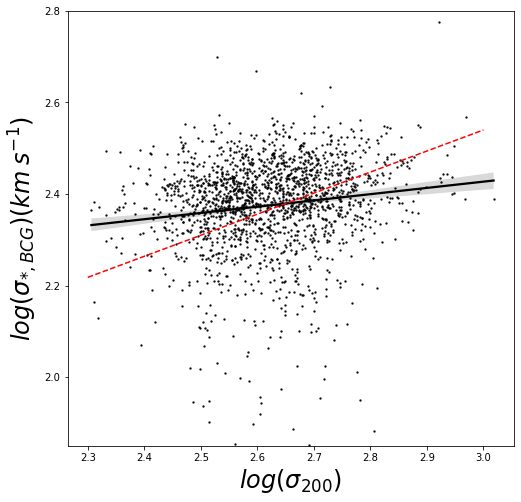

In [660]:
bcg_info['logvelDisp/sigma_200'] = bcg_info.logvelDisp - bcg_info.logsigma_200

_, ax = plt.subplots(1,1, figsize=(8, 8))
ax = sns.regplot(data=bcg_info,
                 x='logsigma_200',
                 y='logvelDisp',
                 color='black',
                 scatter_kws={'s':2})
N = 70
x = np.linspace(2.3, 3, N)
y_sohn = 0.46 * x + 1.16 * np.ones(N)
ax.plot(x, y_sohn, '--', color='red', label='')
# ax.text(2.75, 1.9, 'Slope: 0.14 $\pm$ 0.02\nIntercept: 2.02 $\pm$ 0.06', fontsize=14)
# ax.text(2.75, 1.62, '<Sohn et al. (2019)>\nSlope: 0.46 $\pm$ 0.09\nIntercept: 1.16 $\pm$ 3.45', fontsize=14)


ax.set_xlabel('$log(\sigma_{200})$', fontsize=24)
ax.set_ylabel('$log(\sigma_{*,BCG}) (km\:s^{-1})$', fontsize=24)
# ax.text(14.4, 1.9, 'Slope: 0.0466$\pm$0.010\nIntercept: 1.727$\pm$0.136', fontsize=12)
# ax.set_xlim(13.3, 15)
ax.set_ylim(1.85, 2.8)
plt.show()

$log\sigma_{*,BCG} = (0.14 \pm 0.02)\ log\sigma_{200}  + (2.02 \pm 0.06)$

$log\sigma_{*,BCG} = (0.46 \pm 0.09)\ log\sigma_{200}  + (1.16 \pm 3.45)$  (Sohn et al. 2019)

In [640]:
X = bcg_info.logsigma_200
y = bcg_info['logvelDisp']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logvelDisp   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     34.14
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           6.07e-09
Time:                        22:05:18   Log-Likelihood:                 1450.9
No. Observations:                1800   AIC:                            -2898.
Df Residuals:                    1798   BIC:                            -2887.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.0169      0.061     32.881      0.000       1.897       2.137
logsigma_200     0.1367      0.023      5.843      0.000       0.091       0.183
==============================================================================
Omnibus:                      815.327   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6262.333
Skew:                          -1.960   Prob(JB):                         0.00
Kurtosis:                      11.254   Cond. No.                         72.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [641]:
X = bcg_info.logsigma_200
y = bcg_info['logvelDisp'] - bcg_info.logsigma_200
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     1361.
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          2.64e-222
Time:                        22:05:19   Log-Likelihood:                 1450.9
No. Observations:                1800   AIC:                            -2898.
Df Residuals:                    1798   BIC:                            -2887.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.0169      0.061     32.881      0.000       1.897       2.137
logsigma_200    -0.8633      0.023    -36.891      0.000      -0.909      -0.817
==============================================================================
Omnibus:                      815.327   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6262.333
Skew:                          -1.960   Prob(JB):                         0.00
Kurtosis:                      11.254   Cond. No.                         72.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$log\sigma_{*,BCG} = (0.0497 \pm 0.010)\ log(M_{200}/M_{\odot}) + (1.687 \pm 0.132)$

In [392]:
1/0.0397, 1/0.0497, 1/0.0597

(25.188916876574307, 20.120724346076457, 16.75041876046901)

In [393]:
20.12-16.75, 25.19-20.12

(3.370000000000001, 5.07)

In [396]:
(1.687/0.0497) - (1.819/0.0397)

-11.874977826657684

$log(M_{200}/M_{\odot}) = (20.1_{-3.37}^{+5.07})\ log\sigma_{*,BCG} - (33.9_{-7.90}^{+11.9})$

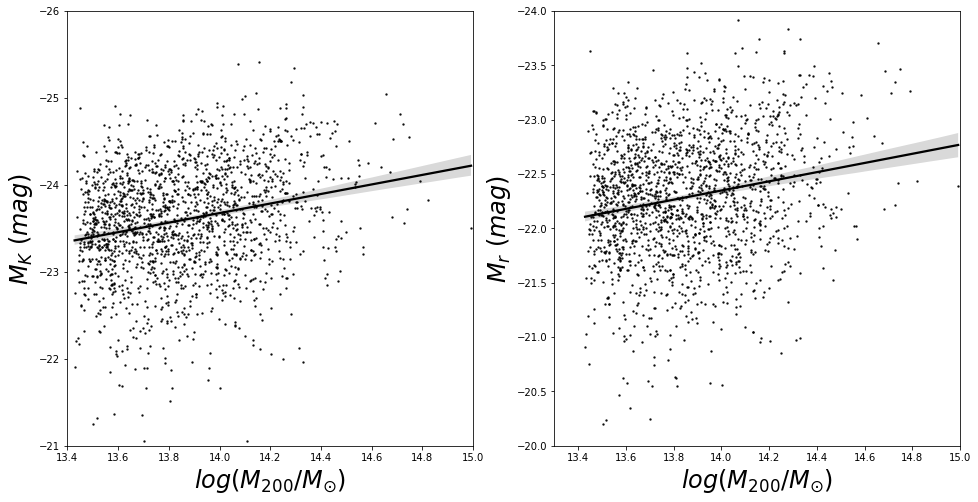

In [705]:
_, ax = plt.subplots(1,2, figsize=(16, 8))
sns.regplot(data=bcg_info[bcg_info.passive_logmass > 10],
            x='logM_200',
            y='absMagK', 
            color='black',
            scatter_kws={'s':2},
            ax=ax[0])

ax[0].set_xlabel('$log(M_{200}/M_{\odot})$', fontsize=24)
ax[0].set_ylabel('$M_{K}\ (mag)$', fontsize=24)
# ax.text(14.6, 10.5, 'Slope: 1.1017$\pm$0.001\nIntercept: 0.9498$\pm$0.024', fontsize=12)
ax[0].set_xlim(13.4, 15)
ax[0].set_ylim(-21, -26)

sns.regplot(data=bcg_info[bcg_info.passive_logmass > 10],
                 x='logM_200',
                 y='absmag_r', 
                 color='black',
                 scatter_kws={'s':2}, ax=ax[1])

ax[1].set_xlabel('$log(M_{200}/M_{\odot})$', fontsize=24)
ax[1].set_ylabel('$M_{r}\ (mag)$', fontsize=24)
# ax.text(14.6, 10.5, 'Slope: 1.1017$\pm$0.001\nIntercept: 0.9498$\pm$0.024', fontsize=12)
ax[1].set_xlim(13.3, 15)
ax[1].set_ylim(-20, -24)
plt.show()

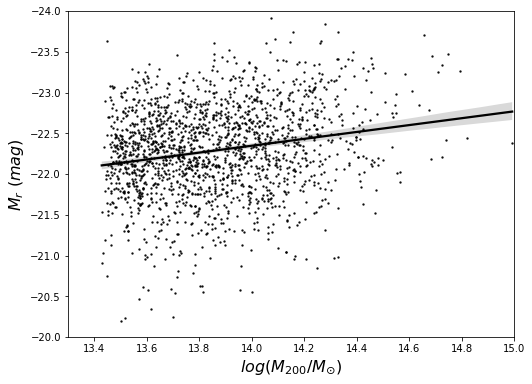

In [651]:
_, ax = plt.subplots(1,1, figsize=(8, 6))
ax = sns.regplot(data=bcg_info[bcg_info.passive_logmass > 10],
                 x='logM_200',
                 y='absmag_r', 
                 color='black',
                 scatter_kws={'s':2})

ax.set_xlabel('$log(M_{200}/M_{\odot})$', fontsize=16)
ax.set_ylabel('$M_{r}\ (mag)$', fontsize=16)
# ax.text(14.6, 10.5, 'Slope: 1.1017$\pm$0.001\nIntercept: 0.9498$\pm$0.024', fontsize=12)
ax.set_xlim(13.3, 15)
ax.set_ylim(-20, -24)
plt.show()

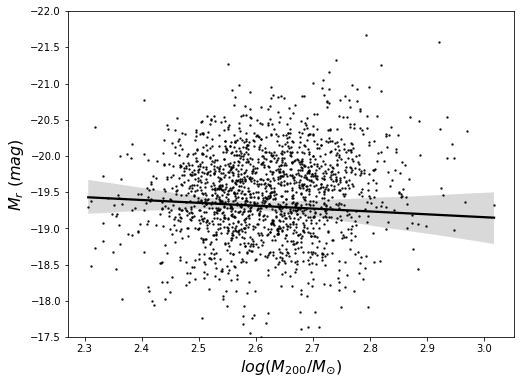

In [645]:
_, ax = plt.subplots(1,1, figsize=(8, 6))
ax = sns.regplot(data=bcg_info[bcg_info.passive_logmass > 10],
                 x='logsigma_200',
                 y='absmag_u', 
                 color='black',
                 scatter_kws={'s':2})

ax.set_xlabel('$log(M_{200}/M_{\odot})$', fontsize=16)
ax.set_ylabel('$M_{r}\ (mag)$', fontsize=16)
# ax.text(14.6, 10.5, 'Slope: 1.1017$\pm$0.001\nIntercept: 0.9498$\pm$0.024', fontsize=12)
# ax.set_xlim(13, 15)
ax.set_ylim(-17.5, -22)
plt.show()

In [465]:
X = bcg_info.logM_200
y = bcg_info.absmag_r
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               absmag_r   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     69.17
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.76e-16
Time:                        13:34:26   Log-Likelihood:                -1547.2
No. Observations:                1800   AIC:                             3098.
Df Residuals:                    1798   BIC:                             3109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.4769      0.698    -23.603      0.000     -17.846     -15.108
logM_200      -0.4189      0.050     -8.317      0.000      -0.518      -0.320
==============================================================================
Omnibus:                      267.974   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              722.925
Skew:                           0.795   Prob(JB):                    1.04e-157
Kurtosis:                       5.666   Cond. No.                         721.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [702]:
X = bcg_info.logM_200
y = bcg_info.absMagK
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                absMagK   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     94.39
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           8.79e-22
Time:                        23:30:21   Log-Likelihood:                -1741.0
No. Observations:                1800   AIC:                             3486.
Df Residuals:                    1798   BIC:                             3497.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.0382      0.777    -20.630      0.000     -17.563     -14.513
logM_200      -0.5450      0.056     -9.716      0.000      -0.655      -0.435
==============================================================================
Omnibus:                      335.977   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1009.865
Skew:                           0.947   Prob(JB):                    5.14e-220
Kurtosis:                       6.143   Cond. No.                         721.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Redshift prediction with photometric features

In [ ]:
import statsmodels.api as sm
gal_df = pd.concat(gal_df_ls).reset_index(drop=True)

In [ ]:
gal_df.columns

In [ ]:
X = gal_df[['mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z']]
y = gal_df.redshift
log_y = np.log10(gal_df.redshift)
log_y

In [ ]:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

In [ ]:
model = sm.OLS(log_y, X).fit()
model.summary()

In [ ]:
lr = lambda u,g,r,i,z: 0.0048 * u + 0.0351 * g - 0.0089 * r - 0.0070 * i - 0.0092 * z - 0.2191
z_photo = lr(gal_df['mag_u'],
             gal_df['mag_g'],
             gal_df['mag_r'],
             gal_df['mag_i'],
             gal_df['mag_z'])

plt.scatter(z_photo, y, color='black')
plt.xlim(0, 0.2)
plt.ylim(0, 0.2)
plt.show()

	coef	std err	t	P>|t|	[0.025	0.975]
    const	-3.0492	0.013	-239.645	0.000	-3.074	-3.024
    mag_u	0.0310	0.001	34.716	0.000	0.029	0.033
    mag_g	0.2152	0.003	83.327	0.000	0.210	0.220
    mag_r	-0.0375	0.004	-10.236	0.000	-0.045	-0.030
    mag_i	-0.0480	0.003	-16.704	0.000	-0.054	-0.042
    mag_z	-0.0662	0.002	-37.173	0.000	-0.070	-0.063
    Omnibus:	21191.929	Durbin-Watson:	0.654
    Prob(Omnibus):	0.000	Jarque-Bera (JB):	310584.579
    Skew:	-1.253	Prob(JB):	0.00
    Kurtosis:	13.712	Cond. No.	698.

In [ ]:
lr2 = lambda u,g,r,i,z: 0.0310 * u + 0.2152 * g - 0.0375 * r - 0.0480 * i - 0.0662 * z - 3.0492
z_photo2 = lr2(gal_df['mag_u'],
               gal_df['mag_g'],
               gal_df['mag_r'],
               gal_df['mag_i'],
               gal_df['mag_z'])
z_photo2 = z_photo2.apply(lambda x: 10 ** x)

plt.scatter(y, z_photo2, color='black')
plt.xlabel('z_spec')
plt.ylabel('z_photo')
plt.xlim(0, 0.2)
plt.ylim(0, 0.2)
plt.show()

In [302]:
# train-test split
from sklearn.model_selection import train_test_split

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm.sklearn import LGBMRegressor
from xgboost.sklearn import XGBRegressor

# metrics
from sklearn.metrics import mean_squared_error, r2_score

In [706]:
X = bcg_info.drop(columns=['logM_200'])
y = bcg_info.logM_200

scores = []
models = [LinearRegression(),
          RandomForestRegressor(random_state=42),
          DecisionTreeRegressor(random_state=42),
          LGBMRegressor(random_state=42),
          XGBRegressor(random_state=42)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for model in models:
    name = str(model).split('(')[0]
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    score = mean_squared_error(y_test, predict, squared=False)
    scores.append(score)
    print(f'---------- Model : {name} ----------')
    print('RMSE score is ', score)
    print()

max_scores_index = scores.index(min(scores))
final = models[max_scores_index]
print("Final model is", models[max_scores_index])
print('R2 score is ', r2_score(y_test, final.predict(X_test)))

---------- Model : LinearRegression ----------
RMSE score is  0.005313719169301542

---------- Model : RandomForestRegressor ----------
RMSE score is  0.004868013103390594

---------- Model : DecisionTreeRegressor ----------
RMSE score is  0.0070291814202860904

---------- Model : LGBMRegressor ----------
RMSE score is  0.006027516349622915

---------- Model : XGBRegressor ----------
RMSE score is  0.008517348564161312

Final model is RandomForestRegressor(random_state=42)
R2 score is  0.9996401143196078


In [ ]:
final_model = models[max_scores_index]
z_photo_rf = final_model.predict(X)

plt.scatter(y, z_photo_rf, color='black')
plt.xlabel('z_spec')
plt.ylabel('z_photo')
plt.xlim(0, 0.2)
plt.ylim(0, 0.2)
plt.show()

In [ ]:
importance = final_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model.estimators_], axis=0)
feature = X.columns
importances = pd.DataFrame({'feature': feature, 'importances': importance, 'std': std})
importances = importances.sort_values('importances', ascending=False)
importances

In [ ]:
plt.figure()
plt.title("Feature Importances")
sns.barplot(data=importances, x='importances', y='feature', palette='viridis')
plt.show()

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm_imp = PermutationImportance(final_model, scoring='r2', random_state=42)
perm_imp.fit(X_test, y_test)
# 순열 중요도 데이터 프레임 생성
perm_imp_df = pd.DataFrame()
feature = X_train.columns

perm_imp_df["feature"] = feature
perm_imp_df["importance"] = perm_imp.feature_importances_
perm_imp_df.sort_values(by='importance', ascending=False, inplace=True)
perm_imp_df.reset_index(drop=True, inplace=True)
perm_imp_df

In [ ]:
eli5.show_weights(perm_imp, feature_names=feature.tolist())

In [ ]:
plt.figure()
plt.title("Permutation Feature Importances")
sns.barplot(data=perm_imp_df, x='importance', y='feature', palette='viridis')
plt.show()